# Overview
This notebook was created to analyse the Airbnb dataset provided by the online data science platform Kaggle. The data can be found through the following [link](https://www.kaggle.com/datasets/mysarahmadbhat/airbnb-listings-reviews?sort=votes).  
Acquiring the data might require registering and logging in to the platform  
DISCLAIMER: The approach used in this notebook is mostly inspired by the following great [notebook](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python)  

# Preliminary: Imports and loading data
Please make sure to have the dataset saved in the workding directory

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [23]:
# variable to determine whether the notebook is running on Collab or not
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [24]:
import os
from zipfile import ZipFile

# please save the data in sample_data folder if the notebook is running on google colab
DOWNLOAD_DIR = "sample_data" if IN_COLAB else os.getcwd() 
file_name = "archive.zip"
file_name_no_zip = "archive"
loc = os.path.join(DOWNLOAD_DIR, file_name)
# opening the zip file in READ mode

if not os.path.isdir(os.path.join(DOWNLOAD_DIR, file_name_no_zip)):
    with ZipFile(loc, 'r') as zip_ref:
        zip_ref.extractall()
        print('Done!')

Done!


In [25]:
from copy import copy
# the relevant datasets are Listings.csv and Reviews.csv

listings_loc = os.path.join(os.getcwd(), "data",'Listings.csv')
reviews_loc = os.path.join(os.getcwd(), "data",'Reviews.csv')

#retrieve the data
ls = pd.read_csv(listings_loc,  encoding='latin1')
revs = pd.read_csv(reviews_loc, encoding='latin1')

ls_org = copy(ls) # keeping a copy of the original dataset
revs_org = copy(revs) # keeping copy of the original dataset for further use

C:\Users\bouab\AppData\Local\Temp\ipykernel_16696\614642634.py:8: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ls = pd.read_csv(listings_loc,  encoding='latin1')


# Helper functions
In this subsection, I write a number of functions that I will use across the jupyter notebook

In [26]:
def get_col_types(df: pd.DataFrame, nunique_as_discrete=20):
    # select all numerical features 
    num_cols = set(list(df.select_dtypes(np.number).columns))
    # any feature that is non-numerical is selected as categorical
    cat_cols = set([c for c in df.columns if c not in num_cols])
    
    # let's further filter the numerical features: those with a small number of unique values are considered categorical
    discrete_num_cols = [col for col in num_cols if len(df.value_counts(col)) <= nunique_as_discrete]
    # add them to the categorical features
    cat_cols.update(discrete_num_cols)
    # update the numerical features
    num_cols = num_cols.difference(cat_cols)
    return list(num_cols), list(cat_cols)

In [27]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

def draw_unique_data_table(df):
    nunique = pd.DataFrame(data=[], columns=['n_unique'])
    for c in df.columns:    
        nunique = pd.concat([nunique, pd.DataFrame({'n_unique': [len(df[c].value_counts())]}, index=[c])])
    return nunique


In [28]:
def map_values(df:pd.DataFrame, columns:list , cols_dicts:dict):
    """ This function will map certain values in each passed to another set of values. The mapping is defined by the cols_dicts
    """
    # first make sure all columns are part of the dataframe
    try:
        df.loc[:, columns] 
    except KeyError:
        print(f"PLEASE MAKE SURE THAT each column in {list(columns)} belongs to the passed dataframe")
    
    # make sure passing a string is acceptable
    if isinstance(columns, str):
        columns = [columns]
    
    # make sure passing a single dictionary is acceptable
    if isinstance(cols_dicts, dict):
        cols_dicts = [cols_dicts]

    # second make sure the lengths of both iterables are the same
    assert len(columns) == len(cols_dicts)

    # map the dictionary and the columns into a single dictionary
    replace_dictionary = dict(zip(columns, cols_dicts))
    # return the new dictionary
    return df.replace(to_replace=replace_dictionary)

In [29]:
def new_col_names(old_new_names, df):
    try:    
        df = df.rename(columns=old_new_names)
    except:
        df_no_col = [col for col in old_new_names.keys if col not in df.columns]
        print(f"PLEASE MAKE SURE THAT each column in {df_no_col} is in the passed dataframe")
    return df

In [30]:
from empiricaldist import Cdf

def display_cdfs(data:pd.DataFrame, y:str, feat:str, feat_values:list=None, title:str=None):
   
    # if the values of the feature are not determined, then we consider all values
    if feat_values is None: 
        feat_values = list(data[feat].value_counts().index)
    
    # construct the conditional cdf of the target 'y' for each unique passed value of 'feat' 
    for v in feat_values:
        d = data[data[feat] == v][y]
        data_cdf = Cdf.from_seq(d)
        data_cdf.plot(label=v)

    plt.legend()
    plt.xlabel(f'{y}')
    plt.ylabel(f'cdf of {feat}')
    plt.title((title if title is not None else f'cdf of {y} with respect to {feat}'))
    plt.show()   


In [31]:
def display_histogram(data, num_feat, cat_feat, figsize=None, title:str=None):
    if figsize is None:
        figsize = (10, 10)
    plt.figure(figsize=figsize)
    cat_unique = list(data.value_counts(cat_feat).index)
    for v in cat_unique:
        plt.hist(data[data[cat_feat] == v][num_feat], bins=100, alpha=0.5, label=f"{cat_feat} == {v}")

    plt.xlabel(f"{num_feat}", size=14)
    plt.ylabel("count", size=14)
    plt.title(title if title is not None else f"{num_feat} distribution for different values of {cat_feat}")
    plt.legend(loc='upper right')
    plt.show()

def display_cat_plot(data: pd.DataFrame, num_feat, cat_feat, num_cat='box', title:str=None):
    g = sns.catplot(data=data, x=num_feat, y=cat_feat, kind=num_cat, orient='h')
    g.fig.suptitle(title if title is not None else f"distribution of {num_feat} for different values of {cat_feat}")
    g.set(xlabel=f"{num_feat}", ylabel=f"{cat_feat}")
    plt.show()

def visualize_num_cat(data: pd.DataFrame, num_feat: str, cat_feat: str, num_cat='box', nunique_as_discrete=20, title=None):
        valid_num_cat = ['cdf', 'hist', 'box', 'violin','boxen']
        num_cat = num_cat.lower()
        
        # make sure to have a meaningful plot
        if num_feat == cat_feat or len(data.value_counts(cat_feat)) > nunique_as_discrete: 
            print(f"THE CATEGORICAL FEATURE {cat_feat} HAS TOO MANY CATEGORIES")
            print("PLEASE MAKE SURE TO HAVE CATEGORICAL FEATURE WITH A REASONABLE NUMBER OF CATEGORIES")
            return
        try:
            assert num_cat in valid_num_cat
            # only display categorical features with reasonable number of categories / unique values
            if num_cat == 'cdf':
                display_cdfs(data, y=num_feat, feat=cat_feat, title=title)
            elif num_cat == 'hist':
                display_histogram(data, num_feat=num_feat, cat_feat=cat_feat, title=title)
            else:
                display_cat_plot(data=data, num_feat=num_feat, cat_feat=cat_feat, num_cat=num_cat, title=title)
        except (KeyError, AssertionError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID num_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {valid_num_cat}")    

def visualize_cat_cat(data: pd.DataFrame, cat1: str, cat2: str, nunique_as_discrete=20, cat_cat='count', hist_stats='percent'):
        # make sure to have a meaningful plot
        if cat1 == cat2 or len(data.value_counts(cat1)) > nunique_as_discrete or len(data.value_counts(cat2)) > nunique_as_discrete: 
            print(f"THE CATEGORICAL FEATURE {cat1} or {cat2} HAS TOO MANY CATEGORIES")
            print("PLEASE MAKE SURE TO HAVE CATEGORICAL FEATURE WITH A REASONABLE NUMBER OF CATEGORIES")            
            return
        
        # the hue parameter should be assigned the feature with the smaller number of possible values
        feats = [cat1, cat2]
        feats = sorted(feats, key=lambda x: len(data.value_counts(x)))
        hue_feat, x_feat = feats
        try:            
            if cat_cat == 'hist':
                sns.histplot(data=data, x=x_feat, hue=hue_feat, stat=hist_stats)
            else:
                sns.catplot(kind=cat_cat, data=data, x=x_feat, hue=hue_feat)                
            plt.xticks(rotation=45)
            plt.show()
        except (AssertionError, KeyError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID cat_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {['count', 'bar', 'hist']}")    
        
def visualize_num_num(data: pd.DataFrame, num1: str, num2: str, num_num='scatter'):
        # make sure to have a meaningful plot
        if num1 == num2: 
            return
        
        try:
            g = sns.relplot(data=data, x=num1, y=num2, kind=num_num)
            g.fig.suptitle(f"The bivaritate distribution of {num1} and {num2}")
            g.set(xlabel=f"{num1}", ylabel=f"{num2}")
            plt.legend('best')
            plt.show()
        except (AssertionError, KeyError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID cat_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {['scatter']}")    


In [32]:
def visualize_interaction(data:pd.DataFrame, feature, use_cols=None, nunique_as_discrete=20, num_cat='box', num_num='scatter', cat_cat='count', num_feats=None, cat_feats=None
, hist_stats='percent'):
    try:
        data[feature]
    except (KeyError):
        print(f"{feature} is not part of the dataframe's features")
        return 

    if use_cols is None:
        use_cols = data.columns

    if isinstance(use_cols, str):
        use_cols = [use_cols] 

    # filter the use_cols to keep only those belonging to the passed dataframe
    use_cols = [column for column in use_cols if column in set(data.columns)]

    if num_feats is None or cat_feats is None:
        # extract the numerical and categorical features, if they are not specified by the user-call
        num_feats, cat_feats = get_col_types(data)

    # consider the case where the passed feat is indeed categorical:
    if feature in cat_feats:
        # iterate through all the columns in the dataset
        for col in use_cols:
            if col in num_feats: 
                visualize_num_cat(data=data, num_feat=col, cat_feat=feature, num_cat=num_cat, nunique_as_discrete=nunique_as_discrete)
            elif col in cat_feats:
                visualize_cat_cat(data=data, cat1=col, cat2=feature, cat_cat=cat_cat, nunique_as_discrete=nunique_as_discrete, hist_stats=hist_stats)
    
    elif feature in num_feats:
        for col in use_cols:
            if col in num_feats:
                visualize_num_num(data=data, num1=col, num2=feature)
            elif col in cat_feats:
                visualize_num_cat(data=data, num_feat=feature, cat_feat=col, num_cat=num_cat, nunique_as_discrete=nunique_as_discrete)    
    

In [33]:
# even though the previous visualization options are quite helpful, sometimes the data analysis purposes require a bit more detailed and statistics-oriented results
# assuming we have a target varaible y and an explantory variable 'x': (categorical)  

def visualize_cond_prob(data: pd.DataFrame, target:str, hue:str, nunique_as_discrete=20):
    try:
        c1 = data[hue] 
        c2 = data[target]    
    except KeyError:
        print(f"PLEASE MAKE SURE BOTH {hue} and {target} ARE COLUMNS OF THE PASSED DATAFRAME")
        return

    if hue == target or len(data[hue].value_counts()) > nunique_as_discrete:
        print("Please make sure to input two different categorical columns")
        return

    # first extract the unique values of each of the passed columns
    target_values = data[target].value_counts().index
    hue_values = data[hue].value_counts().index
    

    # define the resulting dataframe shape
    result = pd.DataFrame(data=[], index=target_values, columns=hue_values)

    for h in hue_values:
        # the number of rows for which the column hue has the value 'h'
        h_count = len(data[data[hue] == h])
        result[h] = data[data[hue] == h][target].value_counts() / h_count

    # counting for the following possibility: certain combination of value of hue and target do not appear in the result
    result.fillna(value=0, inplace=True)

    # visualize the result by creating a heatmap
    g = sns.heatmap(result, annot=True, linewidth=0.5, linecolor='b', cmap=sns.color_palette("rocket_r", as_cmap=True))
    # let's add labels to the axis
    plt.xlabel(f'values of the column {hue}')
    plt.ylabel(f'conditional probabilities {target} on {hue}')
    plt.title(f'condition distribution of {target} on {hue}')
    plt.show()


In [34]:
def detect_outliers(df, column):
    # first calculate the percentiles
    Q3, Q1 = np.percentile(df[df[column].notnull()][column], [75 ,25]) # find the quantiles for non-nan values
    iqr = Q3 - Q1
    lower = Q1 - iqr * 1.5
    upper = Q3 + iqr * 1.5
    return lower, upper    

In [35]:
def plot_correlation(df):
    corrmat = df.corr(numeric_only=True)
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f')
    return corrmat

# Reviews:  The target variables
So, let's see the main goal of our endavour: getting to know the users (Well their reviews is all we got, but should be good enough..) 

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

REVIEWS = [col for col in ls.columns if 'review' in col.lower()]
# let's start by a simple description of our target variable(s)
 
ls[REVIEWS].describe()


,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,188307.000000,187999.000000,188047.000000,187941.000000,188025.000000,187937.000000,187927.000000
mean,93.405195,9.565476,9.312869,9.701534,9.698593,9.633994,9.335364
std,10.070437,0.990878,1.146072,0.867434,0.886884,0.833234,1.042625
min,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000
50%,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


INTERESTING !! Airbnb has such magnificient hosts that only $25\%$ of the listings received a rating lower than 91 out of 100 and only $25\%$ of the hosts are not perfect communicators

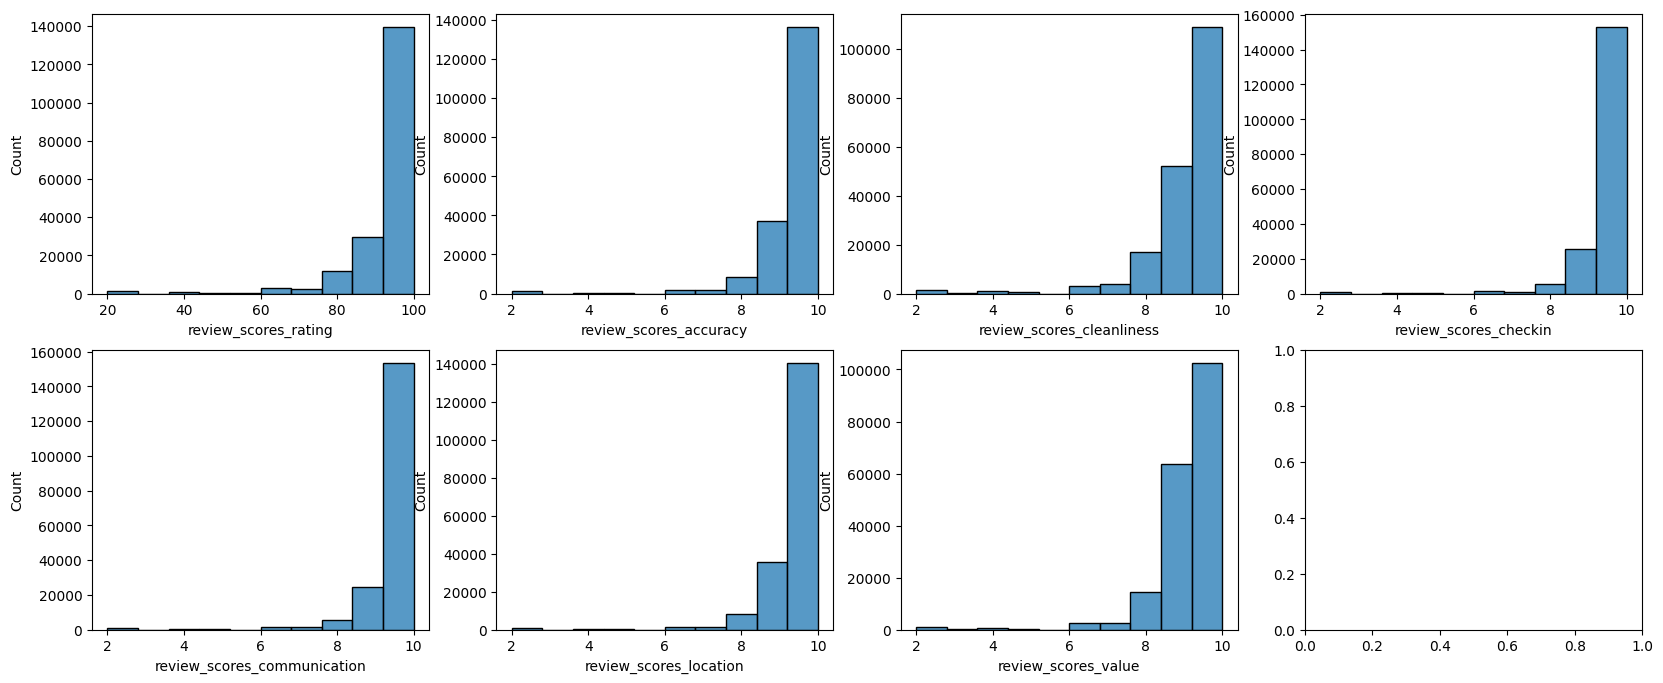

In [37]:
# A visualization would not hurt, right!!
figure, axes = plt.subplots(2, 4,figsize=(20, 8), sharex=False, sharey=False)
for i, rv in enumerate(REVIEWS):  
    sns.histplot(ax=axes[i // 4, i % 4], data=ls, x=rv, bins=10)
plt.show()

In [38]:
# let's measure the skewness of our data.
ls[REVIEWS].skew()

review_scores_rating          -3.758450
review_scores_accuracy        -4.213310
review_scores_cleanliness     -3.027859
review_scores_checkin         -5.262128
review_scores_communication   -5.230256
review_scores_location        -4.317991
review_scores_value           -3.253842
dtype: float64

AS WE CAN SEE, BOTH VISUALIZATION AND DESCRIPTIVE STATISTICS the indeniable inflation of the review scores :The minimum non-outlier value being at least 8 out of 10 (or 80 out of 100) in each of the 7 review scores' categories. The latter proves that reviews cannot reliably reflect the listing or the property's quality.

In the light of the this conclusion, There are two main approaches to be considered:
1. In a perfect world, acquire more data and with higher variance to have a more reliable assessment of the user's experience (maybe actual text data) 
2. Working with the current data, it might be reasonable to convert the current problem into a classification problem. What properties /  listings provide negative 
user-experience (the threshold for positive experience is getting quite high) .

The current dataset is the only one available. Thus, the 2nd approach is the most fruitful.

The 2nd approach itself is not free of issues. We cannot proceed with the converting the problem at hand into a classificaiton without tackling the problem of missing values. The latter can be solved in 2 main ways:  
1. Dropping the missing data
2. Imputing by understanding the relation between the low reviews and the rest of the available features

In [39]:
# the rating has the highest variance. As the rest of the 
# the rating is the review with the highest variance. This one will be used as the main criterial to classify the listings 

RATING_REVIEW = 'review_scores_rating'

Q3, Q1 = np.percentile(ls[ls[RATING_REVIEW].notnull()][RATING_REVIEW], [75 ,25]) # find the quantiles for non-nan values
iqr = Q3 - Q1
THRESHOLD = Q1 - iqr * 1.5
print(Q3, Q1)
print(THRESHOLD)

100.0 91.0
77.5


We can see that the 3-rd percentile of the ratings is the maximum value. It might be more interesting to consider a binary classification problem: which listings are in the lowest quarter 

a first look at the columns shows that the columns can be divided into 4 main categories:
1. host information
2. geographical information (form city all the way to neighborhood and even the exact coordinates)
3. listing description: more detailed objective information about the listing
4. reviews: reviews scores on differents part of the user's experience 

For this analysis, we will use data with no missing values

As expected the problem is quite unbalanced. Let's drop the unnecessary columns and proceed to better understand how the data varies

In [40]:
# remove all reviews' scores now
ls.drop(columns=[r for r in REVIEWS if r != RATING_REVIEW], inplace=True)

# Data Description: Unique and missing values

In [41]:
# let's procceed by removing duplicates, each listing has its own id. Nevertheless, a listing will be considered dupliacted if it has the same features (except the name and the id)
ls = ls.drop_duplicates(subset=list(ls.columns[2:]))
print(len(ls))
# we don't have too many duplicates

# let's rename the columns

new_cols = {"host_response_time": "res_time", "host_acceptance_rate": "acceptance_rate", 'host_response_rate': 'res_rate',
"host_is_superhost":"superhost", "host_total_listings_count": "ls_count", "host_has_profile_pic": "pf", "host_identity_verified": "identity"}

ls = new_col_names(new_cols, ls)

host_dict = {"t": 1, "f": 0}
ls = map_values(ls, columns=['superhost', 'pf', 'identity', 'instant_bookable'], cols_dicts= [host_dict] * 4)


279558


In [42]:
num_cols, cat_cols = get_col_types(ls)
draw_unique_data_table(ls[cat_cols])

,n_unique
city,10
host_since,4240
pf,2
property_type,144
room_type,4
instant_bookable,2
identity,2
superhost,2
amenities,245003
res_time,4


WE'RE LOOKING AT A HUGE NUMBER OF MISSING VALUES !!

In [43]:
# let's investigate the missing values
draw_missing_data_table(ls)

,Total,Percent
district,242564,0.867670
res_time,128737,0.460502
res_rate,128737,0.460502
acceptance_rate,113046,0.404374
review_scores_rating,91309,0.326619
bedrooms,29412,0.105209
host_location,839,0.003001
name,173,0.000619
host_since,165,0.000590
superhost,165,0.000590


The following columns are to be removed:
1. The listing id as it does not introduce any valuable insight
2. The district feature as it has more than $85\%$ missing values and can be easily reconstruced from other present geo-spatial data 
3. the name feature as it represents a lengthy description of the listing. (MIGHT BE PROCESSED IN FURTHER ITERATIONS!!!)
4. host's location as it represents a very large number of unique values

In [44]:
ls.drop(columns=['district', 'listing_id', 'name', 'host_location', 'host_id'], inplace=True)

# Data Description: Correlations with the target variable

,res_rate,acceptance_rate,superhost,ls_count,pf,identity,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,review_scores_rating,instant_bookable,is_positive
res_rate,1.000000,0.297095,0.201259,0.015352,0.028890,0.114208,-0.034466,-0.015884,0.024557,0.012451,0.007083,-0.025244,-0.000204,0.112633,0.086710,0.101647
acceptance_rate,0.297095,1.000000,0.169960,0.043150,0.009318,0.087222,0.057731,0.003097,0.010741,-0.032318,-0.004073,-0.041014,0.000009,-0.017313,0.350685,-0.003310
superhost,0.201259,0.169960,1.000000,-0.033280,0.010301,0.105073,-0.021859,-0.070890,0.038032,0.006705,0.030027,-0.020637,-0.002534,0.201212,0.064649,0.249735
ls_count,0.015352,0.043150,-0.033280,1.000000,0.005196,0.054788,0.005579,0.006118,0.024308,0.018004,0.009518,0.005810,-0.000586,-0.037210,0.079833,-0.044376
pf,0.028890,0.009318,0.010301,0.005196,1.000000,0.031242,-0.004930,-0.002246,0.004004,0.001905,0.004101,-0.003317,0.000188,0.014901,0.004222,0.007822
identity,0.114208,0.087222,0.105073,0.054788,0.031242,1.000000,0.052705,-0.011905,0.054236,0.016407,0.004746,0.008767,0.002347,0.049804,0.027085,0.043122
latitude,-0.034466,0.057731,-0.021859,0.005579,-0.004930,0.052705,1.000000,-0.437919,-0.099732,-0.144340,-0.124765,0.047318,0.001768,-0.034181,0.000028,-0.041662
longitude,-0.015884,0.003097,-0.070890,0.006118,-0.002246,-0.011905,-0.437919,1.000000,0.032637,0.055650,0.024792,-0.059629,-0.001533,-0.048970,0.044481,-0.057658
accommodates,0.024557,0.010741,0.038032,0.024308,0.004004,0.054236,-0.099732,0.032637,1.000000,0.682837,0.170109,-0.030227,0.003961,0.006486,0.022261,0.009328
bedrooms,0.012451,-0.032318,0.006705,0.018004,0.001905,0.016407,-0.144340,0.055650,0.682837,1.000000,0.180991,-0.016024,0.001258,0.009020,-0.023976,0.011845


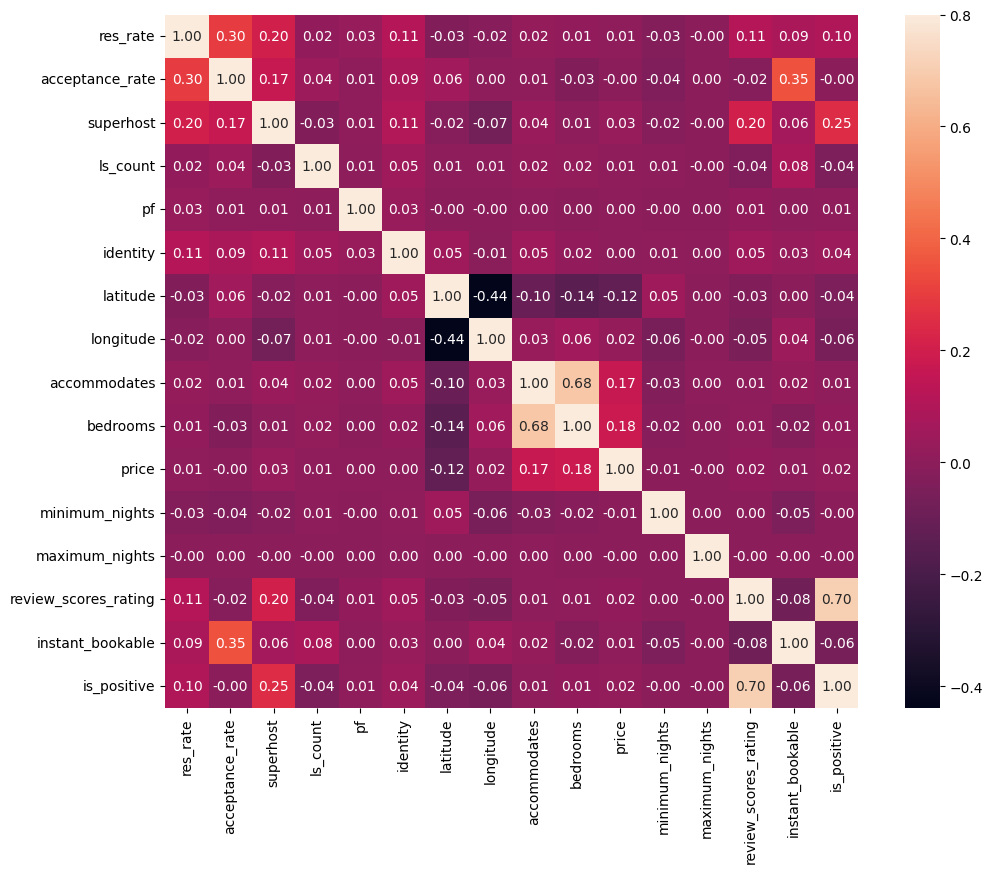

In [45]:
df = ls.dropna(subset=[RATING_REVIEW])

# let's create our target variable
df['is_positive'] = (df[RATING_REVIEW] >= Q1).astype(int)

# let's try to see how things relate to each other before proceeding even further
plot_correlation(df)

WELL, WELL, WHAT DO WE HAVE HERE? MOST OF THE NUMERICAL FEATURES IN THEIR ORIGINAL FORMS EXHIBIT LITTLE TO NO CORRELATION TO THE TARGET VARIABLES. MORE INVESTIGATION IN THAT REGARD IS NEEDED.   
TO BETTER UNDERSTAND THE POSSIBLE TRANSFORMATIONS, IT MIGHT BE NECESSARY TO BETTER UNDERSTAND THE DISTRIBUTIONS OF OUR INDEPENDENT VARIABLES

# Data Distributions

### NUMERICAL FEATURES

['acceptance_rate', 'review_scores_rating', 'maximum_nights', 'latitude', 'res_rate', 'longitude', 'ls_count', 'minimum_nights', 'bedrooms', 'price']


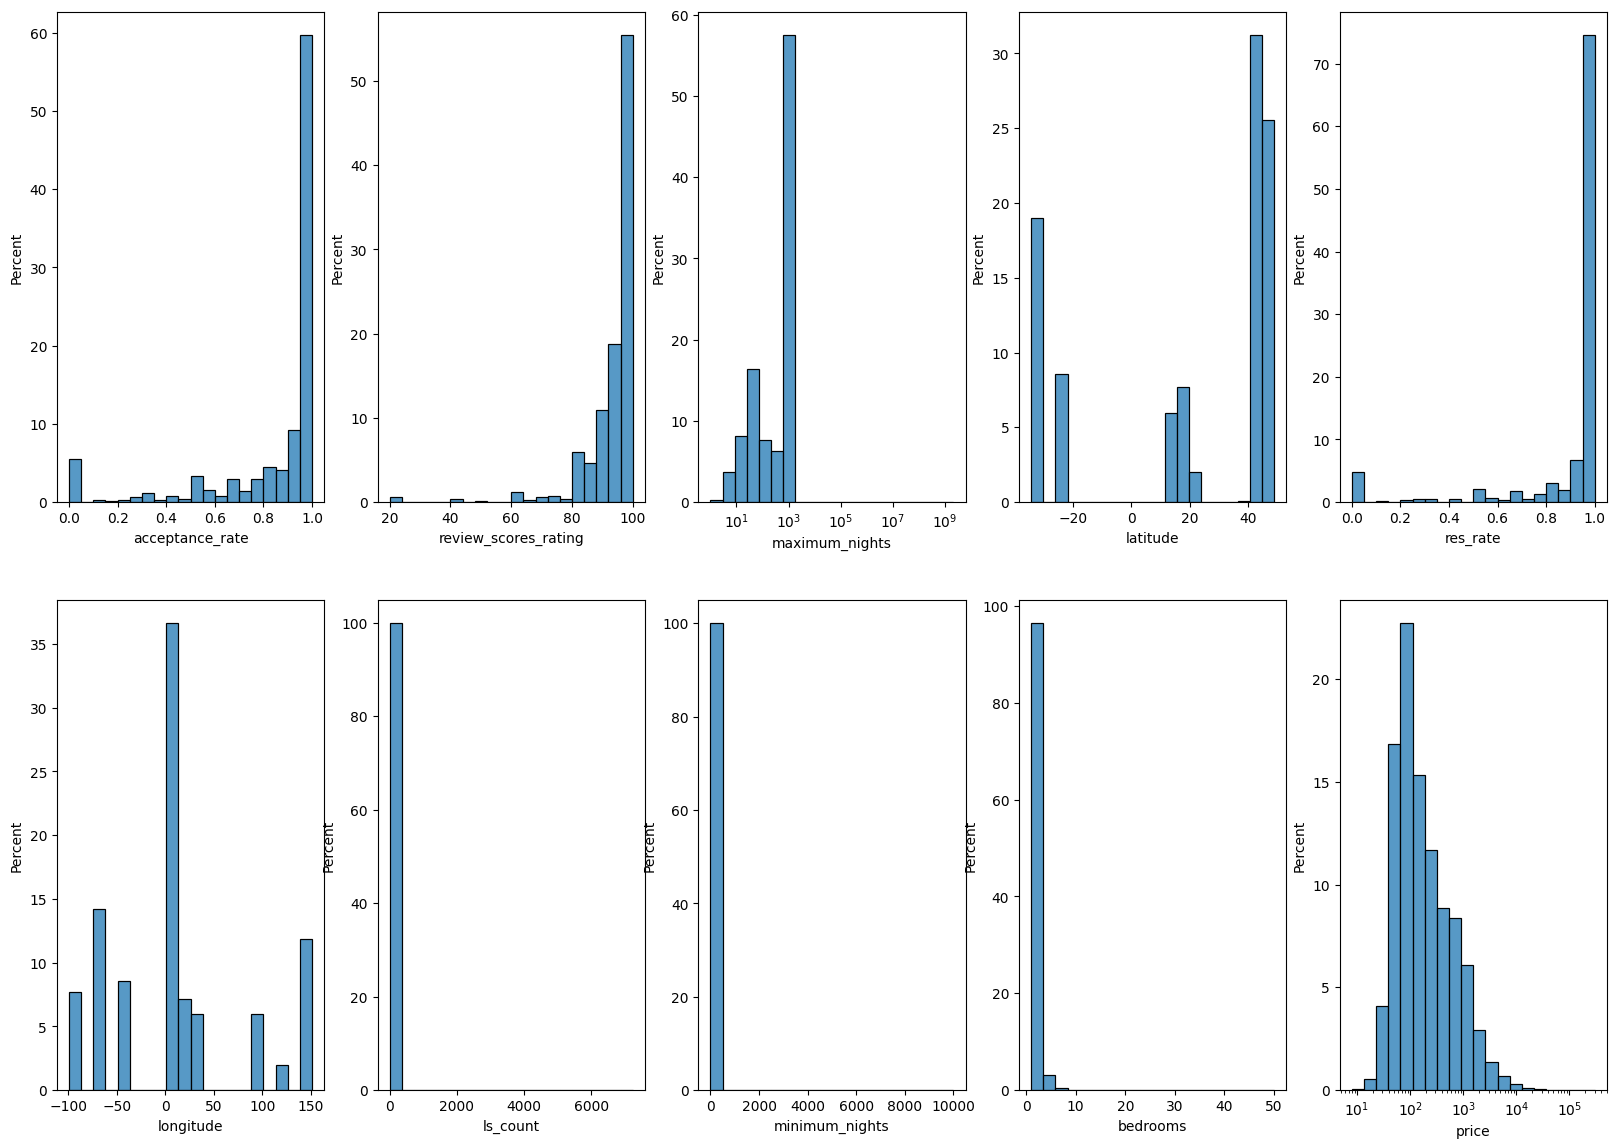

In [46]:
# let's display the distribution of the numerical variables
num_cols, cat_cols = get_col_types(df)
print(num_cols)
# we have 11 numerical features

figure, axes = plt.subplots(2, 5,figsize=(20, 14), sharex=False, sharey=False)
for i, rv in enumerate([n_c for n_c in num_cols if n_c != 'host_id']):  
    log_scale = 10 if np.max(df[rv]) >= 10 ** 4 else None
    sns.histplot(ax=axes[i // 5, i % 5], data=df, x=rv, bins=20, log_scale=log_scale, stat='percent')
plt.show()

* HAVE YOU HEARD OF THE SAYING "LIKE INDEPENDENT VARIABLE, LIKE DEPENDENT VARIABLE" ? WE CAN SEE THAT THE VALUES ARE JUST AS SKEWED AS THE TARGET VARIABLE.


In [47]:
df[num_cols].skew()

acceptance_rate          -2.098673
review_scores_rating     -3.758388
maximum_nights          233.169857
latitude                 -0.760787
res_rate                 -2.751020
longitude                 0.558023
ls_count                 54.968161
minimum_nights          162.878624
bedrooms                 11.899500
price                    52.468490
dtype: float64

What can we do about the skewness of our data, WELL we can address it with a couple of transformations:
* log transformation
* box-cox transformation
* inverse transformations possibly

In [48]:
from scipy.stats import boxcox

def transformations(df: pd.DataFrame, cols:list=None):
    df = df.copy()
    # first extract the numerical features i
    if cols is None:
        cols, cat_cols = get_col_types(df)

    for c_n in cols:
        if (df[c_n] >= 0).all():
            df[f'{c_n}_log'] = np.log(1 + df[c_n])
    
    for c_n in cols: 
        # make sure the data is strictly positive
        if (df[c_n] > 0).all():
            # calculate the new column and the lamda coefficient
            new_col, alpha = boxcox(df[c_n])
            df[f'{c_n}_boxcox_{round(alpha, 3)}'] = new_col

    # drop any generated columns that have nan values
    generated_cols = [c for c in df.columns if 'log' in c or 'boxcox' in c]
    # as pandas does not offer the possibility of removing a subset of columns 
    nan_vals = df[generated_cols].isna().sum() 
    # extract those that have at least one nan value
    cols_to_drop = nan_vals[nan_vals > 0].index
    # drop them
    return df.drop(columns=cols_to_drop)

df_t = transformations(df, cols=[c for c in num_cols if c != 'host_id'] )


In [49]:
# let's extract the trasformed features and see if anything is better now!!!
t_cols = [col for col in df_t.columns if 'log' in col or 'boxcox' in col]
print((t_cols))
print(len(t_cols))

['review_scores_rating_log', 'maximum_nights_log', 'minimum_nights_log', 'price_log', 'review_scores_rating_boxcox_8.252', 'maximum_nights_boxcox_0.157', 'minimum_nights_boxcox_-0.537', 'price_boxcox_-0.278']
8


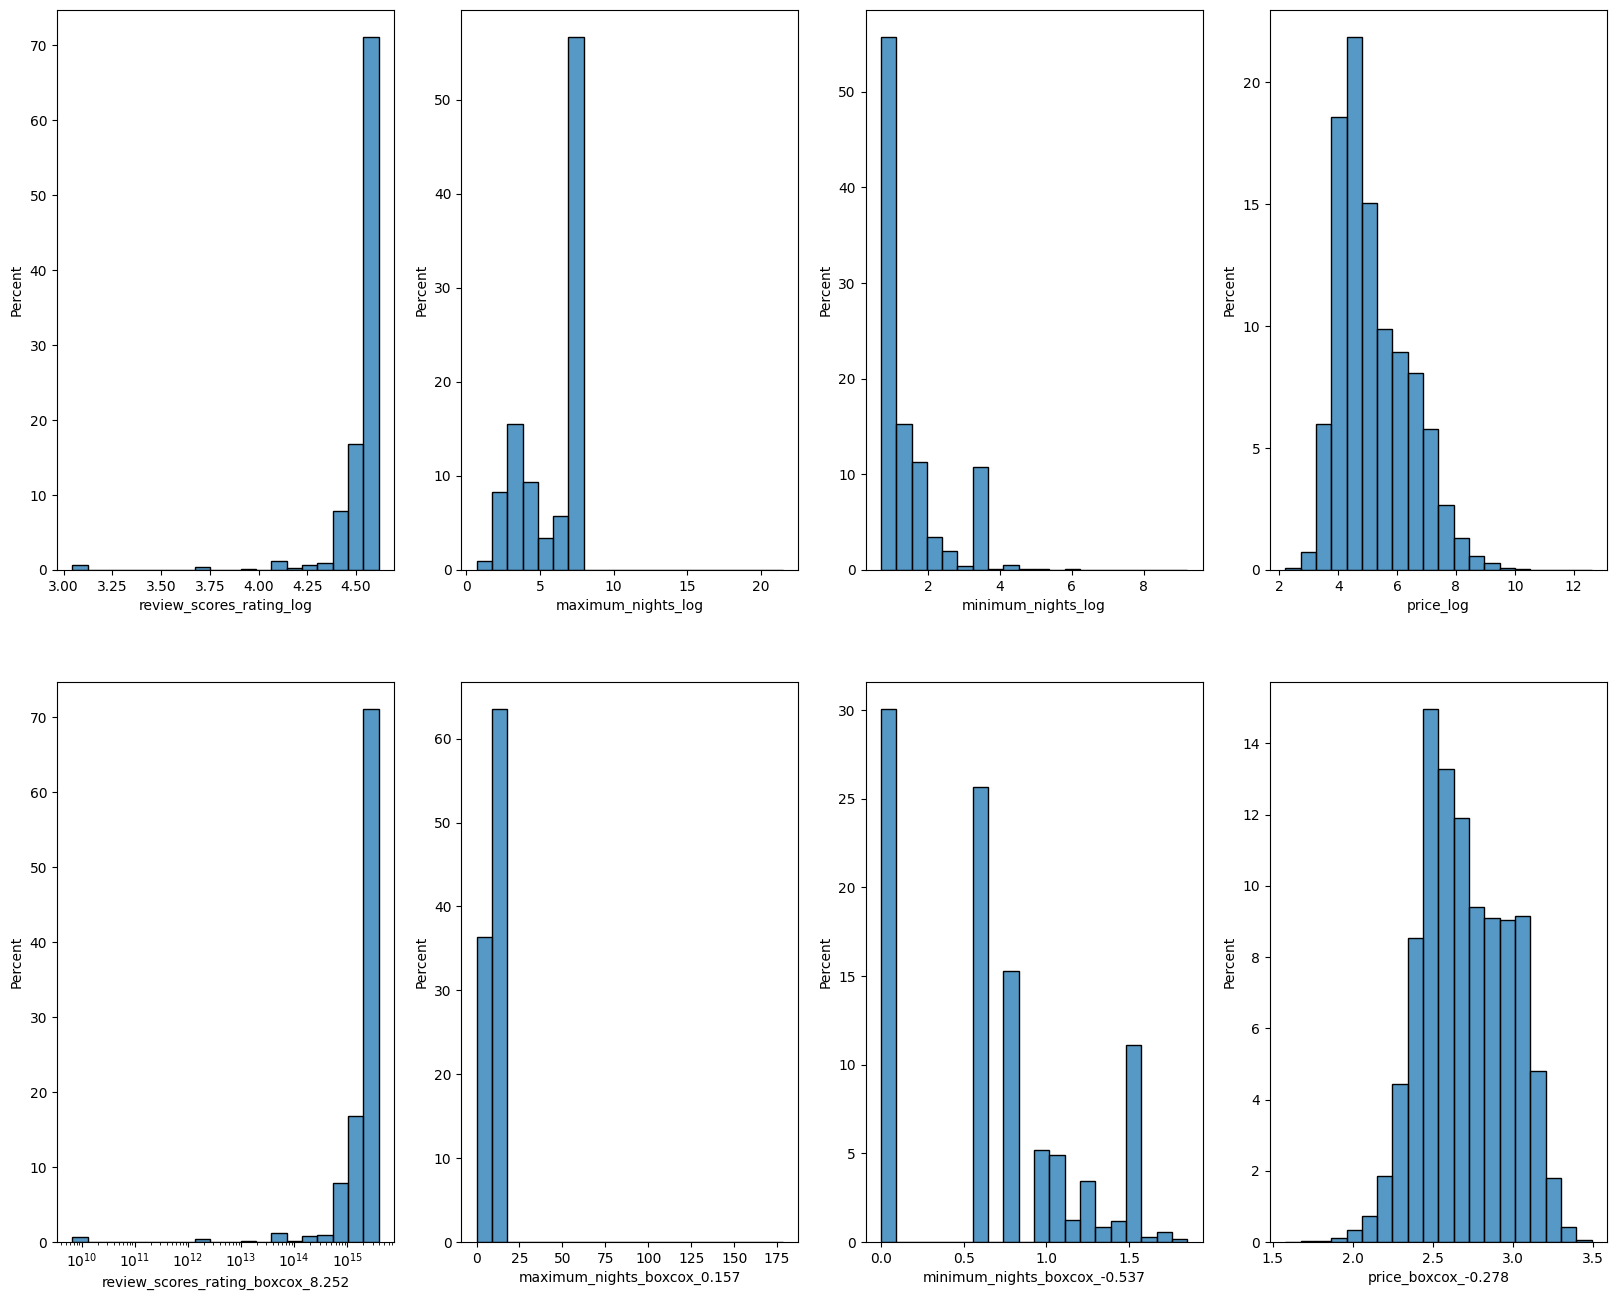

In [50]:
# let's do some more visualization to see if things got any better
figure, axes = plt.subplots(2, 4, figsize=(20, 16), sharex=False, sharey=False)

for i, col in enumerate(t_cols):  
    log_scale = 10 if np.max(df_t[col]) >= 10 ** 4 else None
    sns.histplot(ax=axes[i // 4, i % 4], data=df_t, x=col, bins=20, log_scale=log_scale, stat='percent')
plt.show()

,res_rate,acceptance_rate,superhost,ls_count,pf,identity,latitude,longitude,accommodates,bedrooms,...,instant_bookable,is_positive,review_scores_rating_log,maximum_nights_log,minimum_nights_log,price_log,review_scores_rating_boxcox_8.252,maximum_nights_boxcox_0.157,minimum_nights_boxcox_-0.537,price_boxcox_-0.278
res_rate,1.000000,0.297095,0.201259,0.015352,0.028890,0.114208,-0.034466,-0.015884,0.024557,0.012451,...,0.086710,0.101647,0.111646,0.001676,-0.016792,0.040552,0.082997,-0.002663,0.006477,0.041364
acceptance_rate,0.297095,1.000000,0.169960,0.043150,0.009318,0.087222,0.057731,0.003097,0.010741,-0.032318,...,0.350685,-0.003310,-0.011669,0.050057,-0.122870,0.028392,-0.036991,0.045405,-0.144217,0.030627
superhost,0.201259,0.169960,1.000000,-0.033280,0.010301,0.105073,-0.021859,-0.070890,0.038032,0.006705,...,0.064649,0.249735,0.164273,-0.017742,-0.045296,0.105027,0.229780,-0.024126,-0.026157,0.104980
ls_count,0.015352,0.043150,-0.033280,1.000000,0.005196,0.054788,0.005579,0.006118,0.024308,0.018004,...,0.079833,-0.044376,-0.029324,0.055938,-0.001257,0.041537,-0.040459,0.052656,-0.029008,0.043618
pf,0.028890,0.009318,0.010301,0.005196,1.000000,0.031242,-0.004930,-0.002246,0.004004,0.001905,...,0.004222,0.007822,0.015659,0.002843,-0.004479,0.009584,0.008472,0.002445,-0.001452,0.008967
identity,0.114208,0.087222,0.105073,0.054788,0.031242,1.000000,0.052705,-0.011905,0.054236,0.016407,...,0.027085,0.043122,0.054649,0.043357,0.025303,-0.017032,0.010113,0.038341,0.029092,-0.018520
latitude,-0.034466,0.057731,-0.021859,0.005579,-0.004930,0.052705,1.000000,-0.437919,-0.099732,-0.144340,...,0.000028,-0.041662,-0.020453,-0.008541,0.126281,-0.414315,-0.078816,-0.006170,0.079279,-0.416919
longitude,-0.015884,0.003097,-0.070890,0.006118,-0.002246,-0.011905,-0.437919,1.000000,0.032637,0.055650,...,0.044481,-0.057658,-0.041010,0.009941,-0.205811,0.039593,-0.046665,0.014018,-0.170437,0.035022
accommodates,0.024557,0.010741,0.038032,0.024308,0.004004,0.054236,-0.099732,0.032637,1.000000,0.682837,...,0.022261,0.009328,0.007004,0.048651,-0.057304,0.368602,-0.000718,0.043516,-0.011612,0.361034
bedrooms,0.012451,-0.032318,0.006705,0.018004,0.001905,0.016407,-0.144340,0.055650,0.682837,1.000000,...,-0.023976,0.011845,0.004872,0.017372,-0.006800,0.342733,0.021715,0.014149,0.040619,0.322911


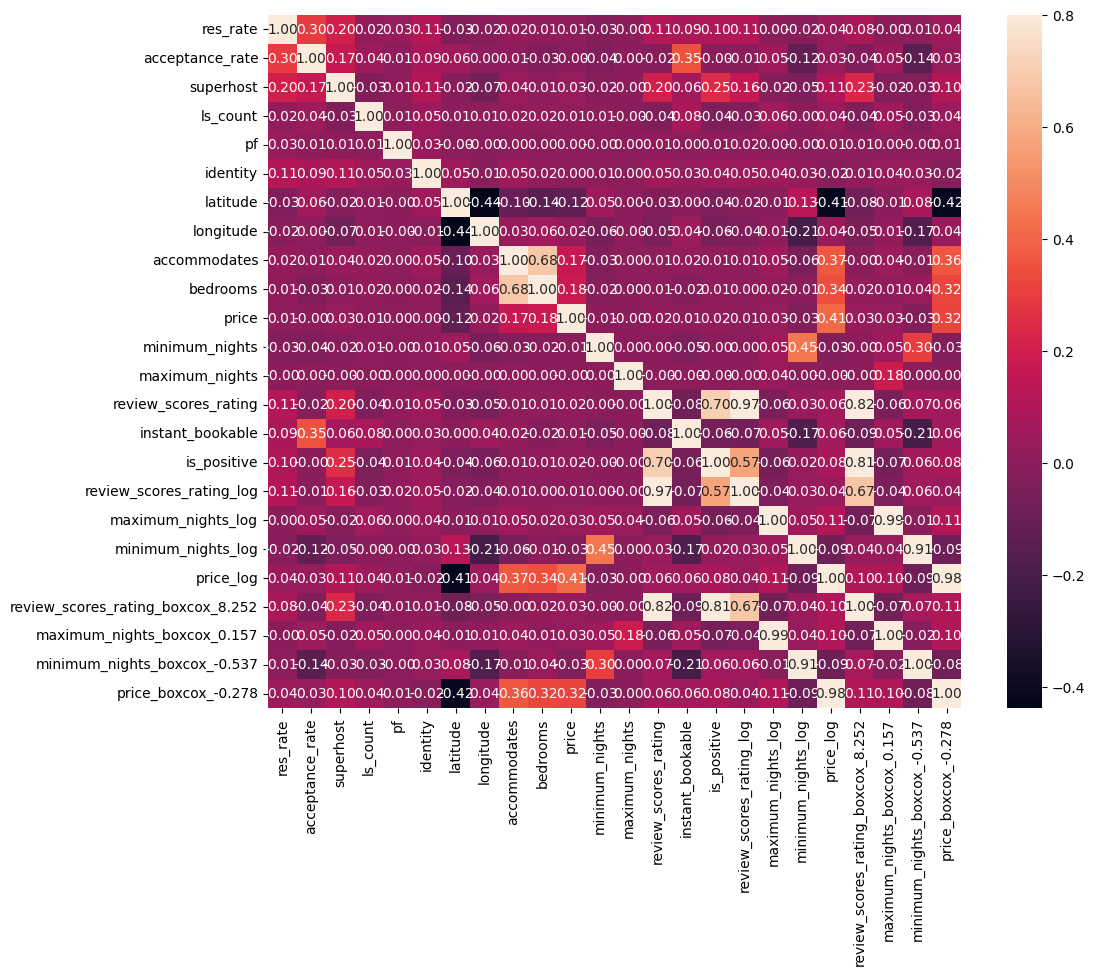

In [51]:
# to better evaluate the quality of our transformations, let's plot the correlastion matrix
plot_correlation(df_t)

IT SEEMS THAT THE MOST COMMON DATA TRANSFORMATIONS TECHNIQUES DID NOT INTRODUCE ANY NOTICEABLE IMPROVEMENT IN THE CORRELATION WITH THE TARGET VARIABLE.  
NEVERTHELESS, WE SHOULD NOT LOSE HOPE... A CHANGE OF PERSPECTIVE IS NEEDED.   
THE SKEWNESS OF THE DATA CAN BE PARTIALLY EXPLAINED BY THE PRESENCE OF OUTLIERS, HOW WOULD OUR DATA LOOK LIKE WITHOUT SUCH DATA POINTS?

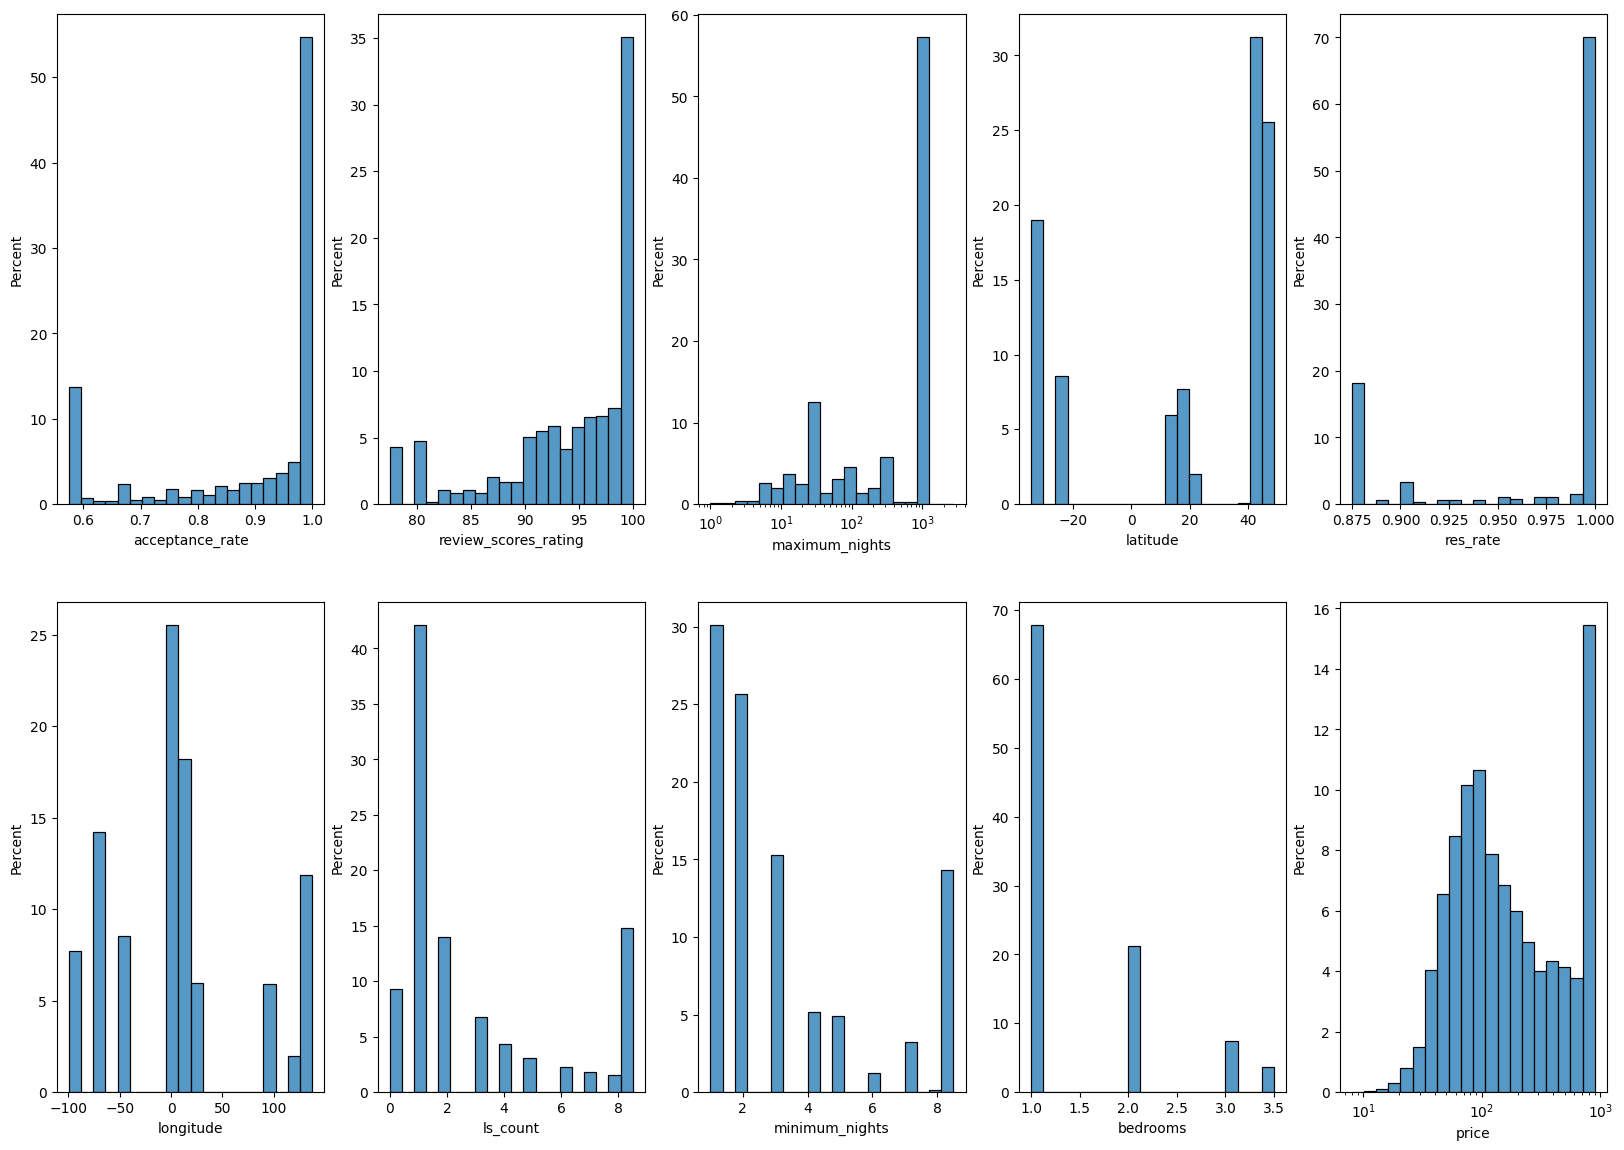

In [52]:
# let's see the distribution of the values after clipping
df_clipped = df.copy()
for n_c in num_cols: 
    lower, upper = detect_outliers(df, column=n_c)
    df_clipped[n_c] = df_clipped[n_c].clip(lower=lower, upper=upper)

# repeating the same code as above, let's see if there is any difference
figure, axes = plt.subplots(2, 5,figsize=(20, 14), sharex=False, sharey=False)
for i, rv in enumerate([n_c for n_c in num_cols if n_c != 'host_id']):  
    log_scale = 10 if np.max(df[rv]) >= 10 ** 4 else None
    sns.histplot(ax=axes[i // 5, i % 5], data=df_clipped, x=rv, bins=20, log_scale=log_scale, stat='percent')
plt.show()

We can see that clipping the outliers (whether outliers with low or high values) generate a more descriptive and detailed description of the dataset. Throwing the outliers is not a sound decision as this type of rows do encode quite a lot of information. Let's investigate what outliers have to offer.


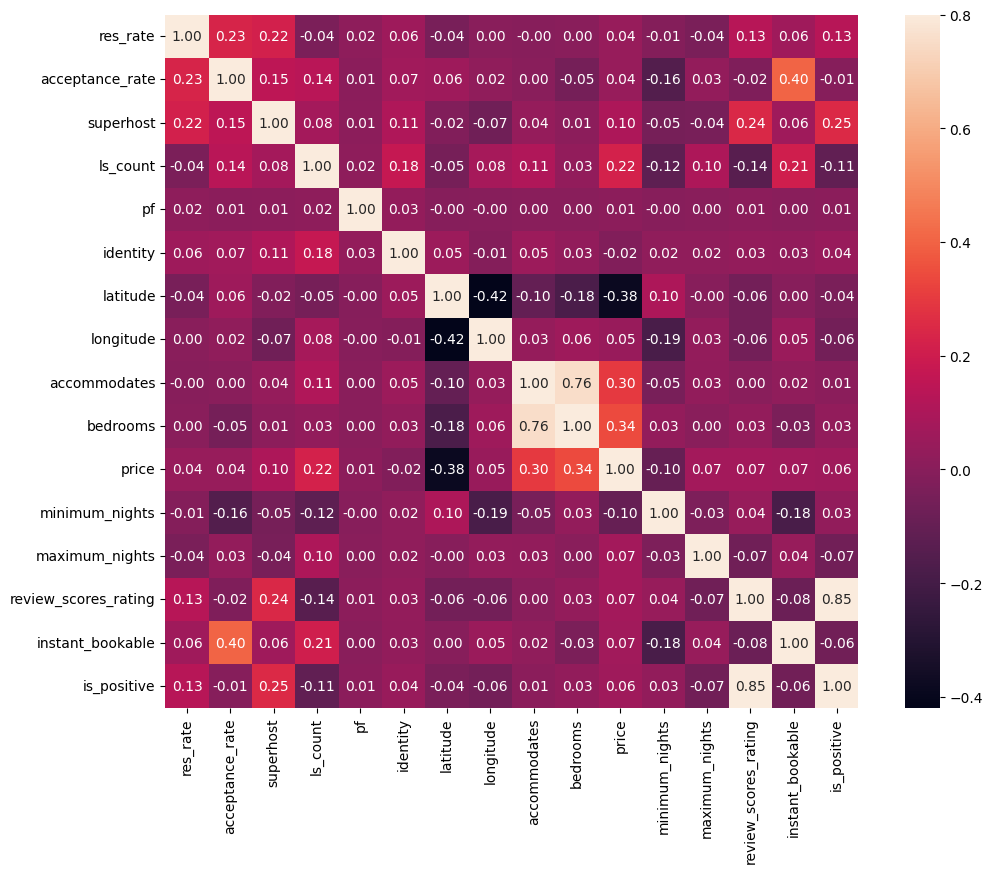

In [53]:
corr = plot_correlation(df_clipped)

WE can see that clipping the data SLIGHTLY increases in the values of the correlations with the target variable. This slight improvement is not enough of a reason to discard the outliers.

### Data Description: An outlier perspective.

In [54]:
def outliers_per_row(data: pd.DataFrame, cols:list=None, return_outliers:bool=False):
    if cols is None:
        num_cols, _ = get_col_types(data)
        cols = num_cols
    
    df_num = data.loc[: , cols]
    lowers, uppers = list(map(list, zip(*[detect_outliers(data, n_c) for n_c in cols])))

    # create a dataframe of lower values
    lower_df = pd.DataFrame(dict([(n_c, [lower] * len(data)) for n_c, lower in zip(cols, lowers)]))
    upper_df = pd.DataFrame(dict([(n_c, [upper] * len(data)) for n_c, upper in zip(cols, uppers)]))

    # set the indices of both arrays to that of the original array

    upper_df.index = df_num.index.copy()
    lower_df.index = df_num.index.copy()

    assert list(df_num.columns) == list(lower_df.columns) and list(df_num.columns) == list(upper_df.columns) 
    assert df_num.shape == lower_df.shape and df_num.shape == upper_df.shape

    df_out_lower = (df_num < lower_df) # true will mean the value at the cell is indeed an outlier by being less than th
    df_out_upper = (df_num > upper_df) # true will mean the value at the cell is indeed an outlier

    df_outliers = (df_out_lower | df_out_upper).astype(int)

    # defining the outliers
    df_out  = df_outliers.sum(axis=1)

    # modify the original dataframe to include the number of outliers    
    df = data.copy()
    df['num_outliers'] = df_out.values
    
    if return_outliers:
        return df, df_outliers
    
    return df, 

In [55]:
num_cols, _ = get_col_types(df)
df, df_out = outliers_per_row(df, cols=[n_c for n_c in num_cols if n_c != 'host_id'], return_outliers=True)
df_out.head()

,acceptance_rate,review_scores_rating,maximum_nights,latitude,res_rate,longitude,ls_count,minimum_nights,bedrooms,price
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [56]:
# let's add the target variable to the df_out and see how the variables correlate
df_out['is_positive'] = df['is_positive'].values
df_out.corr()['is_positive']

acceptance_rate         0.015288
review_scores_rating   -0.378521
maximum_nights         -0.005494
latitude                     NaN
res_rate               -0.068590
longitude              -0.010035
ls_count               -0.109178
minimum_nights         -0.008736
bedrooms                0.010695
price                   0.040981
is_positive             1.000000
Name: is_positive, dtype: float64

WE CAN SEE THAT THE HIGHEST CORRELATION BETWEEN THE OUTLIERS OF A COLUMN AND THE TARGET VARIABLE IS IN THE VACINITY OF 0.14 (NOT COUNTING THE REVIEW_SCORES_RATINGS). THIS DEMONSTRATES THAT OUTLIERS ARE NOT OF DIRECT INTEREST TO OUR OBJECTIVE.  
IN THE REST OF THE NOTEBOOK, WE WILL WORKING WITH THE CLAPPED DATA.

In [57]:
df = df_clipped.copy()

### CATEGORICAL FEATURES

11


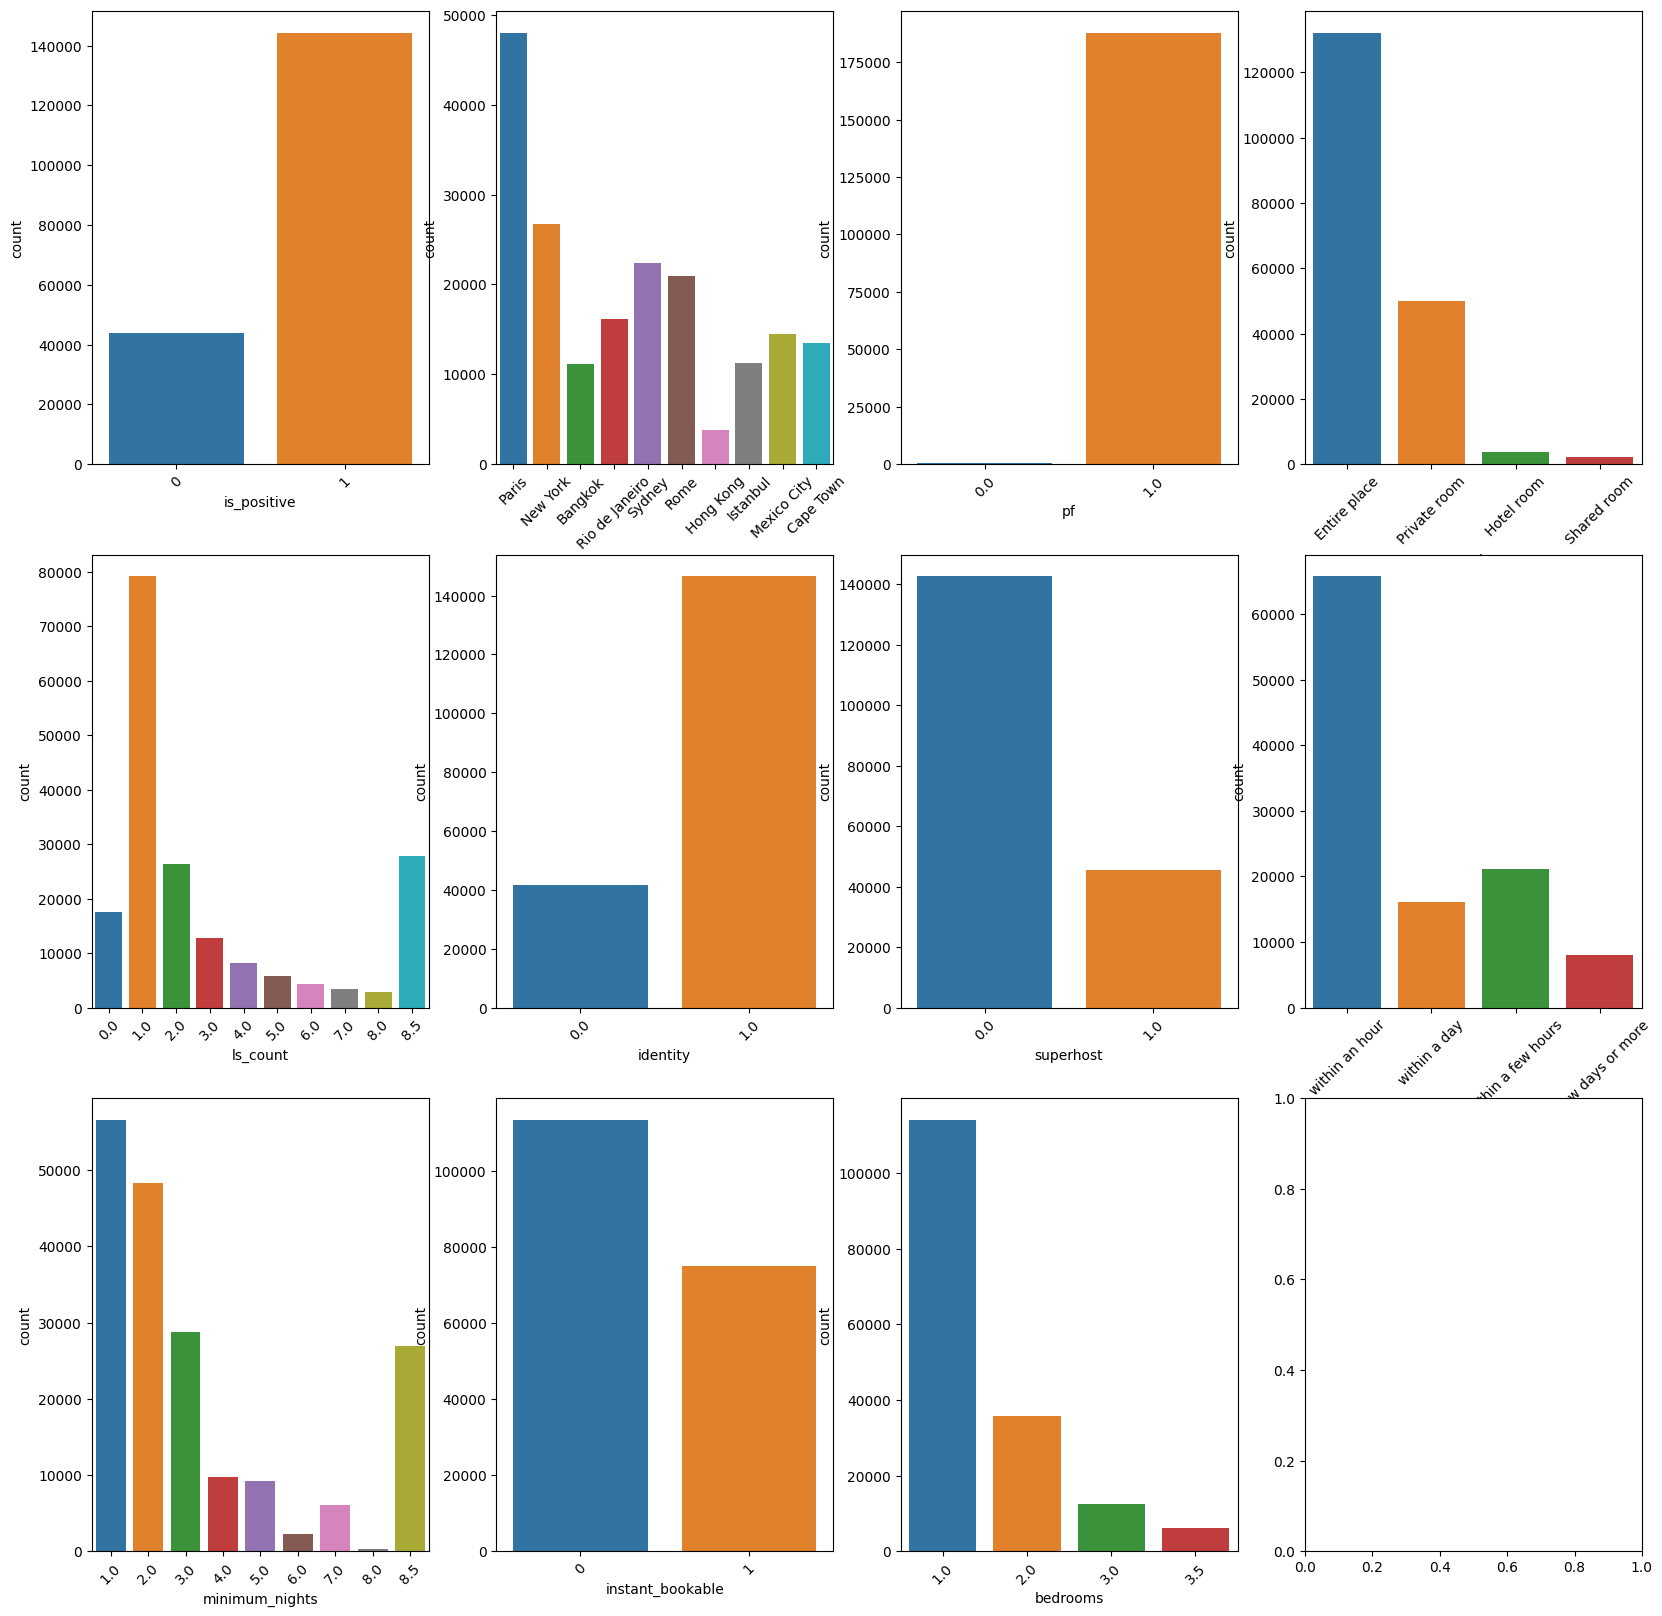

In [58]:
# let's consider the distributions for categorical columns as 
num_cols, cat_cols = get_col_types(df, nunique_as_discrete=10)

print(len([c for c in cat_cols if len(df[c].value_counts()) <= 10]))

figure, axes = plt.subplots(3, 4,figsize=(20, 20), sharex=False, sharey=False)
for i, f in enumerate([c for c in cat_cols if len(df[c].value_counts()) <= 10]):  
    chart = sns.countplot(ax=axes[i // 4, i % 4], data=df, x=f)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

UNLIKE THE NUMERICAL FEATURES, THE CATEGORICAL FEATURES VARY SIGNIFICANTLY MORE IN TERMS OF DISTRIBUTIONS, AS WE CAN FIND: 
1. HEAVILY UMBALANCED FEATURES: host_has_profile_pic, host_identity_verified
2. SLIGHTLY UNBALANCED: host_is_superhost, res_time
3. QUITE BALANCED: instant_bookable, city

OUT OF THE 14 CATEGORICAL VARIABLES IN OUR DATAFRAME, 11 OF THEM HAVE AT MOST 10 UNIQUE VALUES. SUCH OBSERVATION SUGGESTS THE PROBLEM OF LARGE NUMBER OF UNIQUE VALUES. LET'S INVESTIGATE THIS ISSUE A BIT MORE.

# Bridging the gap between description and preparation: reducing unique values

## categorical columns

In [59]:
num_cols, cat_cols = get_col_types(df)
draw_unique_data_table(df)

,n_unique
host_since,4194
res_time,4
res_rate,14
acceptance_rate,44
superhost,2
ls_count,10
pf,2
identity,2
neighbourhood,627
city,10


THE FEATURES NEIGHBORHOOD, HOST_SINCE, PROPERTY_TYPE AND AMENITIES CAN PROVIDE INFORMATIVE INSIGHT (FROM A DOMAIN KNOWLEDGE PERSPECTIVE). NEVERTHELESS, THE LARGE NUMBER OF UNIQUE VALUES MAY STAND IN THE WAY TO TAKING FULL ADVANTAGE OF SUCH COLUMNS.

### host_since feature

In [60]:
from datetime import datetime
df['host_since'] = pd.to_datetime(df['host_since'])
today = datetime.today()
datem = datetime(today.year, today.month, 1)
df['now'] = datem
df['exp'] = (df['now'] - df['host_since']).dt.days // 30 # approximate the number of months
# since the data has not being updated in around 2 years, the final values will be the result of subtracting around 24 months
df['exp'] = df['exp'] - 23 

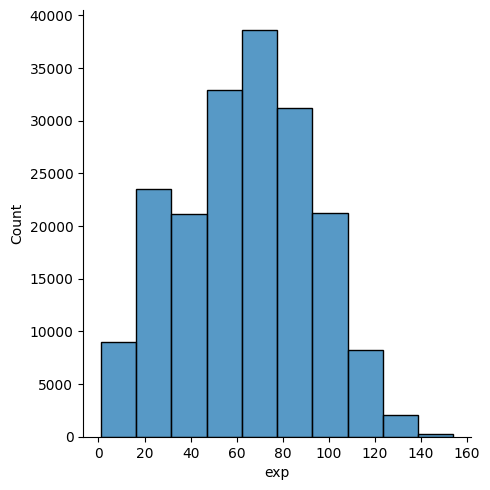

In [61]:
 # let's see how the new feature varies
sns.displot(df, x='exp', bins=10)
plt.show()
# time to set the host_since back
df['host_since'] = df['exp']
df.drop(columns=['exp', 'now'], inplace=True)
# the result is a beautiful bell-shaped distribution  

THE HOST_SINCE FEATURE IS NOW A NUMERICAL VARIABLE REPRESENTING THE HOST'S EXPERIENCE (THEORETICALLY) WITH A QUASI-NORMAL DISTRIBUTION. OUR FEATURE ENGINEERING SEEMS TO WORK WELL SO FAR!!!

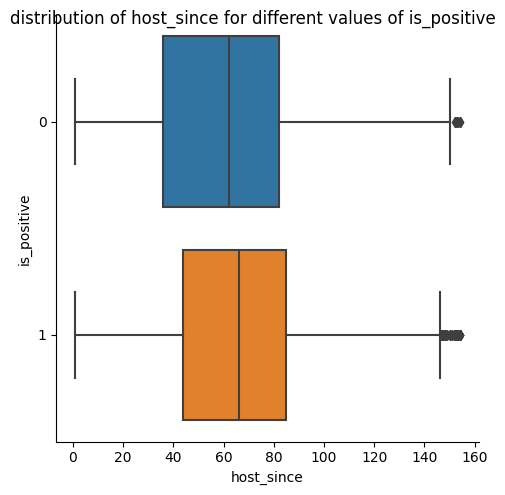

In [62]:
# let's visualize the relation between host_since and the is_positive value
visualize_num_cat(data=df, num_feat='host_since', cat_feat='is_positive', num_cat='box')

NEVERTHELESS THE NUMBER HOST EXPERIENCE'S DOES NOT SEEM TO INTERACT SIGNIFICANTLY WITH THE TARGET VARIABLE.

### The type of the listing
Let's consider the different variables that represent the types of the listing

In [63]:
print(df['room_type'].value_counts())
print(df['property_type'].value_counts())

Entire place    132169
Private room     50107
Hotel room        3764
Shared room       2209
Name: room_type, dtype: int64
Entire apartment             102607
Private room in apartment     28269
Entire house                   8635
Private room in house          8216
Entire condominium             7783
                              ...  
Shared room in floor              1
Private room in treehouse         1
Entire vacation home              1
Private room in tipi              1
Lighthouse                        1
Name: property_type, Length: 125, dtype: int64


We can see that the property type feature introduces additional information as well as complexity. $106$ unique values is quite a large number. Let's try to understand how the target variable varies with respect to the ***room_type*** feature.

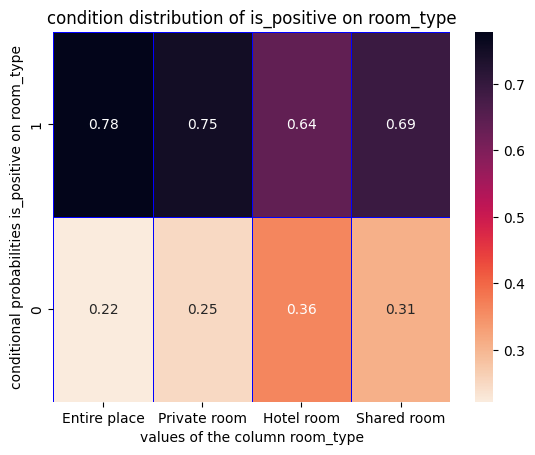

In [64]:
visualize_cond_prob(data=df, target='is_positive', hue='room_type')

The type of the property might not be a determining factor in the review, as the current values are quite close to the generat distribution of the binary classes of the target variable. Nevertheless, the exact number of bedrooms or the number of guests to accommodate is more likely to affect user's review.  

TO ELABORATE IN MORE DETAILS, it might be more important for an entire place to accomodate more guests, while for private / shared rooms to accomodate the least number of guests

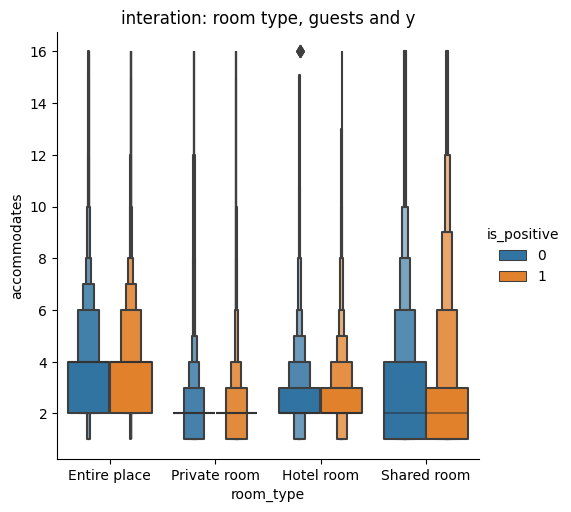

In [65]:
# let's understand the interaction between the target variable, room_type and the number of guests
sns.catplot(data=df, x='room_type', y='accommodates', hue='is_positive', kind='boxen')
plt.title('interation: room type, guests and y')
plt.show()

THE PLOTS ABOVE SHOW THAT THE TYPE OF LISTINGS MIGHT BE OF NO OR LITTLE IMPORTANCE WHEN PREDICTING THE TARGET VARIABLE.

In [66]:
# we can see that the largest variation is in the 'Entire place' column. We can infer the (average) area of the property from the property type feature

from collections import Counter
import re
# a list to save the building blocks
properties = Counter()

for value in df['property_type']:
    # first convert to lower case, remove any training and heading spaces and split the text
    new_val = value.lower().strip()
    # split the
    properties.update(re.split(r'\s+', new_val))

print(properties)

HOUSE_TYPES = set([t for t, v in properties.items() if v >= 2000 and t not in ['entire', 'private', 'in']])
print(HOUSE_TYPES)

Counter({'apartment': 135651, 'entire': 131369, 'room': 56504, 'in': 56296, 'private': 47212, 'house': 17440, 'condominium': 10294, 'loft': 4469, 'hotel': 4465, 'serviced': 3697, 'townhouse': 3555, 'boutique': 3046, 'bed': 2801, 'and': 2801, 'breakfast': 2801, 'guest': 2767, 'suite': 2767, 'shared': 2209, 'hostel': 1585, 'guesthouse': 1578, 'villa': 1168, 'aparthotel': 824, 'cottage': 489, 'tiny': 268, 'bungalow': 267, 'place': 143, 'cabin': 104, 'farm': 68, 'stay': 68, 'chalet': 50, 'boat': 39, 'earth': 34, 'resort': 32, 'nature': 32, 'lodge': 32, 'camper/rv': 28, 'casa': 27, 'particular': 27, 'home/apt': 21, 'floor': 17, 'houseboat': 13, 'barn': 13, 'island': 13, 'hut': 10, 'dorm': 10, 'tent': 9, 'dome': 9, 'treehouse': 8, 'yurt': 7, 'castle': 7, 'minsu': 7, 'campsite': 6, 'cave': 5, 'pension': 5, 'kezhan': 4, 'train': 2, 'bus': 2, 'lighthouse': 2, 'in-law': 1, 'tipi': 1, 'vacation': 1, 'home': 1, 'holiday': 1, 'park': 1})
{'boutique', 'townhouse', 'bed', 'serviced', 'loft', 'house',

In [67]:
def set_listing_type(row):
    properties = row['property_type'].lower().strip()
    properties = re.split(r'\s', properties) 
    for p in properties:
        if p in HOUSE_TYPES:
            row['listing_type'] = p
            return row
    # set the rest to other
    row['listing_type'] = 'Other'
    return row

df = df.apply(set_listing_type, axis=1)

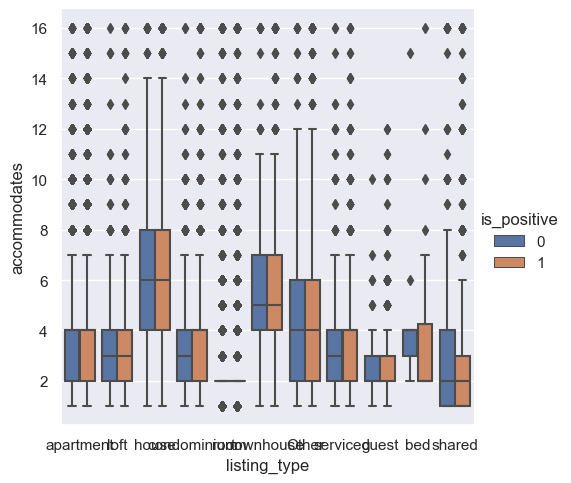

In [68]:
# let's see how the listing_type 

sns.set(rc={"figure.figsize":(5, 5)})
g = sns.catplot(data=df, y='accommodates', x='listing_type', hue='is_positive', kind='box')
plt.show()

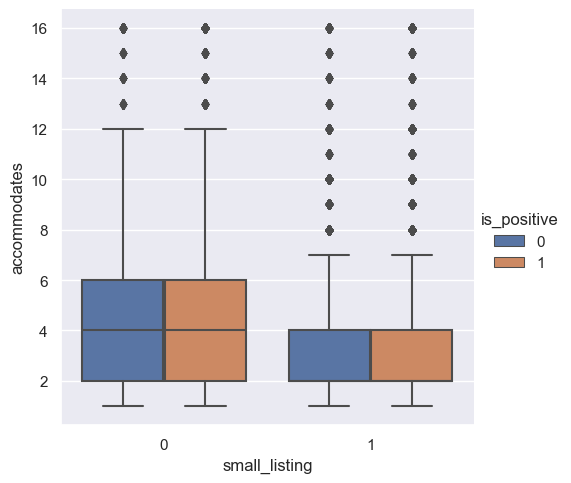

In [69]:
# the number of guests is seemingly significant only for small listings: room, apartment, loft...
# let's verify this hypothesis
df['small_listing'] = df['listing_type'].isin(['apartment', 'loft', 'room']).astype(int)
sns.catplot(data=df, y='accommodates', x='small_listing', hue='is_positive', kind='box')


THE ANALYSIS ABOVE INDICATES, that despite considering several transformations and categorizations of the listing's type, no relevant interaction was found. The type of listing will be dropped from the data.

### Bedrooms and guests

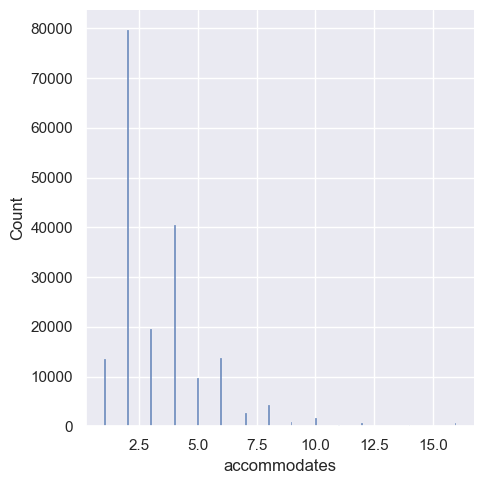

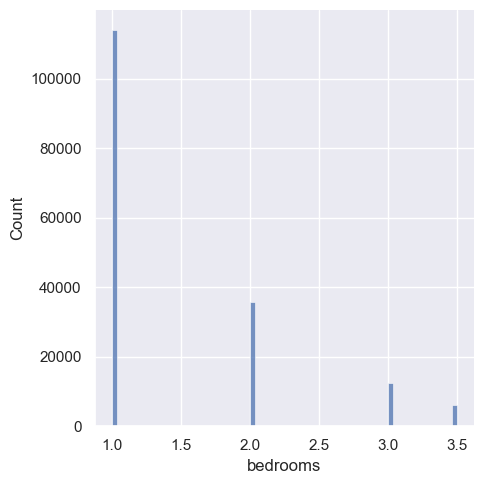

In [70]:
# let's see if the number of guests can be linked to the price.
# first let's display the distribution of the number of guests
sns.displot(data=df, x='accommodates')
sns.displot(data=df, x='bedrooms')
plt.show()

In [71]:
df['bedrooms'] = df['bedrooms'].apply(np.ceil)
print(df[['bedrooms', 'is_positive', 'accommodates']].corr())

              bedrooms  is_positive  accommodates
bedrooms      1.000000     0.024692      0.766064
is_positive   0.024692     1.000000      0.009328
accommodates  0.766064     0.009328      1.000000


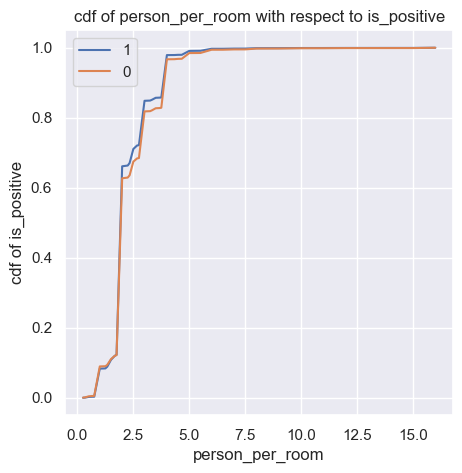

In [72]:
# we can see that the number of guests and bedrooms are quite correlated. The number of bedrooms per person might represent an even more informative feature
df['person_per_room'] = df['accommodates'] / df['bedrooms']
visualize_num_cat(df, num_feat='person_per_room', cat_feat='is_positive', num_cat='cdf')

THE PLOTS + THE CORRELATION SIMPLY PROVES THAT THE NUMBER OF GUESTS CAN BE PREDICTED FROM THE NUMBER OF BEDROOMS AND VICE VERSA. NEVERTHELESS, THE EXACT NUMBER OF GUESTS SEEMS SLIGHTLY MORE INFORMATIVE. THUS IT IS THE ONE TO BE KEPT.

In [73]:
df.columns

Index(['host_since', 'res_time', 'res_rate', 'acceptance_rate', 'superhost',
       'ls_count', 'pf', 'identity', 'neighbourhood', 'city', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'instant_bookable', 'is_positive',
       'listing_type', 'small_listing', 'person_per_room'],
      dtype='object')

In [74]:
df.drop(columns=['bedrooms', 'property_type', 'room_type', 'bedrooms', 'person_per_room', 'listing_type', 'small_listing'], inplace=True)

### Ameneties

In [75]:
# let's have a test of the amenities
print(df['amenities'].iloc[0])
print(df['amenities'].iloc[1])
print(df['amenities'].iloc[2])

["Heating", "Kitchen", "Washer", "Wifi", "Long term stays allowed"]
["Shampoo", "Heating", "Kitchen", "Essentials", "Washer", "Dryer", "Wifi", "Long term stays allowed"]
["Heating", "TV", "Kitchen", "Washer", "Wifi", "Long term stays allowed"]


In [76]:
import re
from collections import Counter
# let's try to tackle the problem of amenities.
ameneties_counter = Counter()

for a in df['amenities']:
    a = a[1:-1] # the field is a string and not a list
    # let's remove any non-alpha numerical characters
    a = re.sub('[^\w\s,-]', '', a)
    ameneties_counter.update([a.strip() for a in re.split(r',', a.lower())])
    
print(len(ameneties_counter))
print(ameneties_counter)

2321
Counter({'wifi': 179030, 'essentials': 176447, 'kitchen': 165787, 'long term stays allowed': 163255, 'hangers': 150712, 'tv': 144533, 'hair dryer': 137504, 'iron': 135547, 'heating': 130818, 'hot water': 130388, 'dedicated workspace': 129883, 'shampoo': 126411, 'washer': 126019, 'smoke alarm': 112698, 'dishes and silverware': 106519, 'refrigerator': 104618, 'air conditioning': 94715, 'cooking basics': 94162, 'microwave': 85257, 'bed linens': 82165, 'stove': 79756, 'coffee maker': 76245, 'elevator': 71242, 'oven': 70676, 'fire extinguisher': 67727, 'dryer': 64044, 'carbon monoxide alarm': 59614, 'first aid kit': 59039, 'extra pillows and blankets': 52584, 'free street parking': 49864, 'private entrance': 49622, 'cable tv': 47963, 'luggage dropoff allowed': 46340, 'free parking on premises': 45256, 'host greets you': 43707, 'patio or balcony': 42533, 'dishwasher': 37430, 'paid parking off premises': 30684, 'lock on bedroom door': 28898, 'garden or backyard': 24335, 'pool': 22710, 'b

In [77]:
# let's remove any amenity that does not appear in at least 5% of the listings.
FINAL_AMENITIES = [a for a, freq in ameneties_counter.items() if freq >= 0.05 * len(df)]
print(FINAL_AMENITIES)

['heating', 'kitchen', 'washer', 'wifi', 'long term stays allowed', 'shampoo', 'essentials', 'dryer', 'tv', 'hair dryer', 'bathtub', 'elevator', 'cable tv', 'smoke alarm', 'fire extinguisher', 'paid parking off premises', 'iron', 'hot water', 'hangers', 'dedicated workspace', 'host greets you', 'carbon monoxide alarm', 'dishwasher', 'stove', 'refrigerator', 'oven', 'dishes and silverware', 'coffee maker', 'cooking basics', 'garden or backyard', 'bed linens', 'cleaning before checkout', 'indoor fireplace', 'breakfast', 'first aid kit', 'air conditioning', 'luggage dropoff allowed', 'microwave', 'single level home', 'patio or balcony', 'extra pillows and blankets', 'private entrance', 'ethernet connection', 'pack u2019n playtravel crib', 'lockbox', 'free street parking', 'shower gel', 'childrenu2019s books and toys', 'crib', 'high chair', 'building staff', 'free parking on premises', 'bbq grill', 'gym', 'pool', 'room-darkening shades', 'lock on bedroom door']


The next step is to assign a numerical score for the amenity: V1 - V2 where
1. V1 is the average frequency of the amenity in listings with positive reviews
2. V2 is the averge frequency of the amenity in the listings with negative reviews

In [78]:
NEGATVE_AMENTIY_COUNTER = Counter()
POSITIVE_AMENTIY_COUNTER = Counter()

def set_amentities(row):
    # first let's clean the amenities
    a = row['amenities']
    a = a[1:-1]
    a = re.sub('[^\w\s,-]', '', a)
    # only keep the needed amenities
    final_a = [a.strip() for a in re.split(r',', a.lower()) if a.strip() in FINAL_AMENITIES]
    
    # update the frequency of each item in the corresponding counter
    if row['is_positive']:
        NEGATVE_AMENTIY_COUNTER.update(final_a)
    else:
        POSITIVE_AMENTIY_COUNTER.update(final_a)
    
    # set the result to the row value
    row['final_amenities'] = final_a

    return row

# apply this function on each row in the dataframe

In [79]:
df = df.apply(set_amentities, axis=1)

The next step is to estimate the conditional probability:
$$ P(positive | amenity~a) = \frac{P(positive~\&~a)}{P(a)}  = \frac{\frac{count(positive~\&~a)}{count(listings)}}{\frac{count(a)}{count(listings)}} = \frac{count(positive~\&~a)}{count(a)}$$

In [80]:
# after running the cells above, we can estimate the conditional probability: P(positive | amenity a present) for each of the most frequent amenitie
AMENITIES_COND_PROB = Counter()

for a in FINAL_AMENITIES:
    # first extract positive count
    pos_count = POSITIVE_AMENTIY_COUNTER[a]
    # extract the negative count as well to cover the denominator
    neg_count = NEGATVE_AMENTIY_COUNTER[a]
    AMENITIES_COND_PROB.update({a:(pos_count / (pos_count + neg_count))})

In [81]:
# let's how our amenities are doing
print(AMENITIES_COND_PROB)

Counter({'long term stays allowed': 0.24008453033597746, 'lock on bedroom door': 0.23700602117793618, 'heating': 0.2322004617101622, 'elevator': 0.22902220600207743, 'building staff': 0.22846693536348708, 'wifi': 0.2273808858850472, 'essentials': 0.22683298667588567, 'tv': 0.22592072398690957, 'smoke alarm': 0.22584251716978118, 'kitchen': 0.22509002515275625, 'air conditioning': 0.2226257720530011, 'shampoo': 0.2187546969804843, 'hangers': 0.2147207919740963, 'fire extinguisher': 0.21455254182231606, 'washer': 0.213793158174561, 'gym': 0.21295316589630783, 'breakfast': 0.21159377169493207, 'dedicated workspace': 0.20998899009108196, 'hair dryer': 0.20736124040027926, 'private entrance': 0.20609810164846237, 'free parking on premises': 0.2048568145660244, 'pool': 0.20303830911492735, 'iron': 0.201819295152235, 'carbon monoxide alarm': 0.2003388465796625, 'dryer': 0.19976890887514834, 'hot water': 0.19878363039543517, 'cleaning before checkout': 0.19727134916624559, 'cable tv': 0.197110

In [82]:
# now we have a way to numerically represent the amenities column in our table
def convert_amenities(row):
    # first iterate through the final amenities
    # extract the amenities
    score = sum([np.log(1 + AMENITIES_COND_PROB[a]) for a in row['final_amenities']])
    # score = np.exp(np.mean([AMENITIES_COND_PROB[a]  for a in row['final_amenities']]) if row['final_amenities'] else 0) 
    row['amenities_score'] = score
    return row 
    # let's consider


In [83]:
df= df.apply(convert_amenities, axis=1)

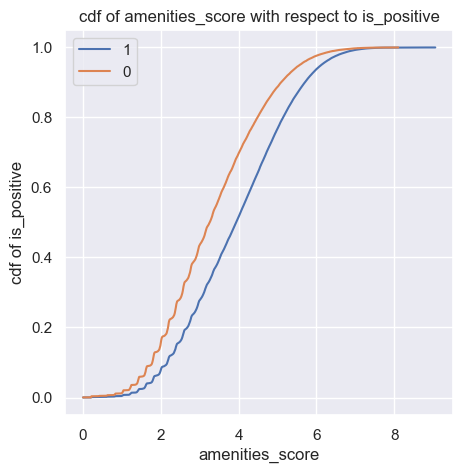

In [84]:
# let's visualize the amenities_score and see if our feature engineering led to any useful insights
visualize_num_cat(data=df, num_feat='amenities_score', cat_feat='is_positive', num_cat='cdf')

In [85]:
# Certain values of the amenities include the term 'host'. Even though no such amenity had a frequency larger than 5%, it is still worth investigating this point further
def host_engagement(row):
    row['host_as_amenity'] = int('host' in row['amenities'].lower().strip())
    return row

df = df.apply(host_engagement, axis=1)

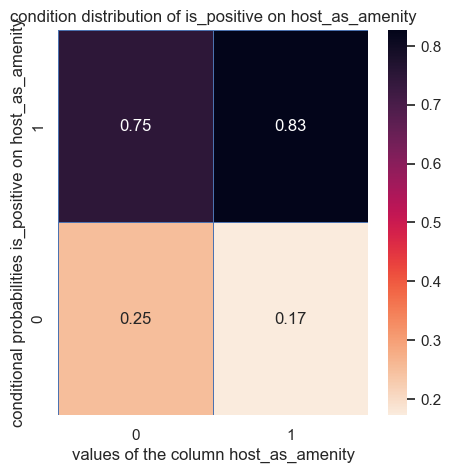

In [86]:
visualize_cond_prob(data=df, target='is_positive', hue='host_as_amenity')

## Numerical columns

In [87]:
# let's first the describe method for a general overview
df[num_cols].describe()

,acceptance_rate,review_scores_rating,maximum_nights,latitude,longitude,price
count,128950.000000,188249.000000,188249.000000,188249.000000,188249.000000,188249.000000
mean,0.892976,94.260870,685.083236,19.692617,7.745119,280.332884
std,0.154840,6.487672,516.638007,32.653482,69.469014,292.562731
min,0.575000,77.500000,1.000000,-34.264400,-99.339630,8.000000
25%,0.830000,91.000000,45.000000,-22.963490,-43.207410,70.000000
50%,0.990000,96.000000,1125.000000,40.720380,2.372570,134.000000
75%,1.000000,100.000000,1125.000000,48.826900,28.963540,400.000000
max,1.000000,100.000000,2745.000000,48.904250,137.219965,895.000000


We can see that the number of maximum nights is completely insignficant after a certain threshold. Such value can be determined by inspecting the amenity: 'long term stays allowed'. Let's dive directly into it.

In [88]:
# let's connect the dots
LONG_TERM_ALLOWED = 'long term stays allowed'
def set_long_term(row):
    row['long_term'] = LONG_TERM_ALLOWED in row['final_amenities'] 
    return row
df = df.apply(set_long_term, axis=1)

In [89]:
# let's see the distribution of the values depending on the new boolean field
print(df[df['long_term'] == True].describe()['maximum_nights'])
print(df[df['long_term'] == False].describe()['maximum_nights'])

count    163255.000000
mean        780.713577
std         481.246317
min          28.000000
25%         150.000000
50%        1125.000000
75%        1125.000000
max        2745.000000
Name: maximum_nights, dtype: float64
count    24994.000000
mean        60.448068
std        218.388116
min          1.000000
25%          7.000000
50%         14.000000
75%         20.000000
max       1125.000000
Name: maximum_nights, dtype: float64


The number of maximum nights are not quite informative for the very simple reason that a client would choose to book the listing only if their stay aligns with the indiciated range.

In [90]:
# time to drop the unnecessary columns
df.drop(columns=['maximum_nights', 'minimum_nights', 'long_term'], inplace=True)

### number of listings
The number of listings might or might not be informative. Generally more listings should reflect more host experience. Nevertheless, more listings require more attention, maintenance and efforts from the host. Can we reflect this observation through combining the different features ? 

In [91]:
df.columns

Index(['host_since', 'res_time', 'res_rate', 'acceptance_rate', 'superhost',
       'ls_count', 'pf', 'identity', 'neighbourhood', 'city', 'latitude',
       'longitude', 'accommodates', 'amenities', 'price',
       'review_scores_rating', 'instant_bookable', 'is_positive',
       'final_amenities', 'amenities_score', 'host_as_amenity'],
      dtype='object')

In [92]:
df['listing_exp'] = (np.log(1 + df['host_since'])) / (np.sqrt(1 + df['ls_count']))

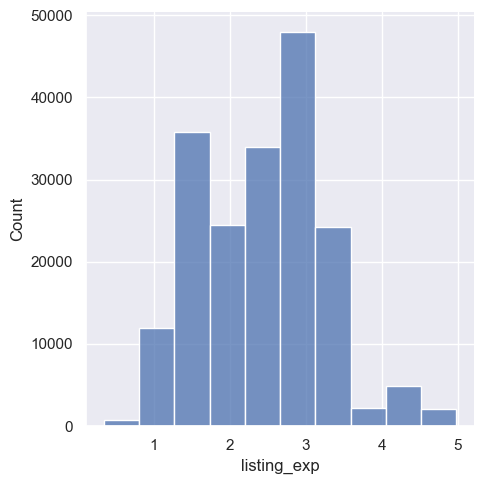

In [93]:
sns.displot(df, x='listing_exp', bins=10)
plt.show()

In [94]:
print(df[['listing_exp', 'is_positive']].corr())

             listing_exp  is_positive
listing_exp     1.000000     0.115226
is_positive     0.115226     1.000000


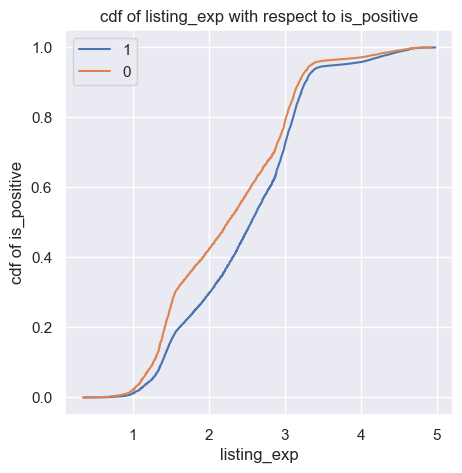

In [95]:
visualize_num_cat(df, num_feat='listing_exp', cat_feat='is_positive', num_cat='cdf')

# Further Data Analysis

## Host information 
In the rest of the analysis, we will consider only the data with non-missing values

In [96]:
# first let's define variable for each type of columns
HOST_COLS = ['res_rate', 'res_time', 'acceptance_rate', 'superhost', 'pf', 'identity']

In [97]:
# for easier and faster manipulation, we will extract the host-related columns and work with sub-dataframe
host_df = df.loc[:, HOST_COLS]
host_df.head()
# let's add the price of the stay to the temporary dataframe
host_df['is_positive'] = df['is_positive'] 

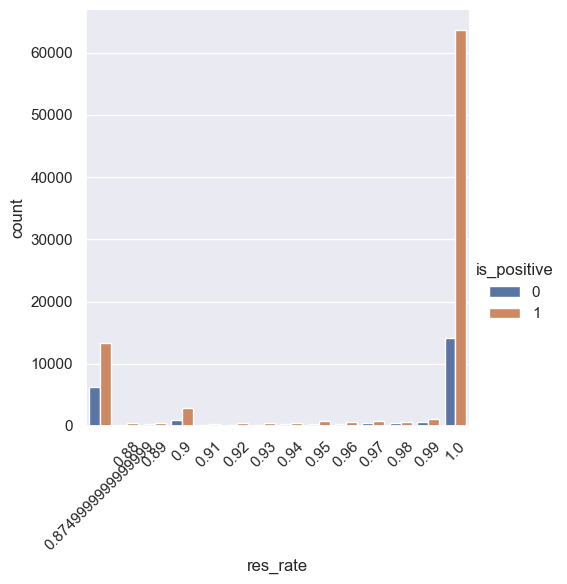

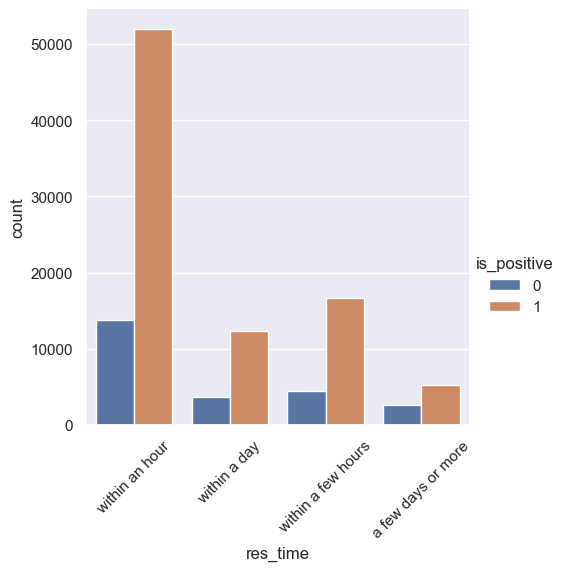

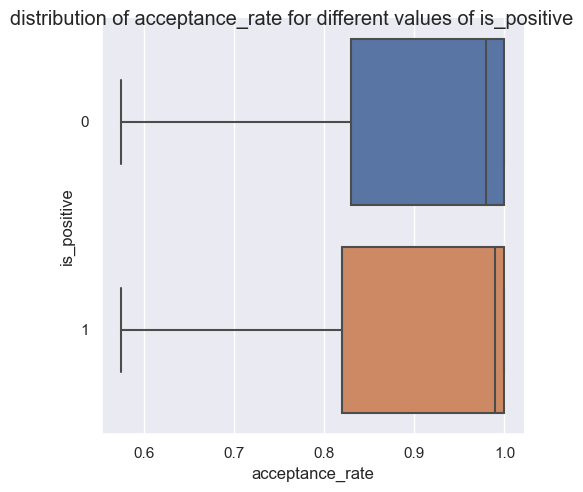

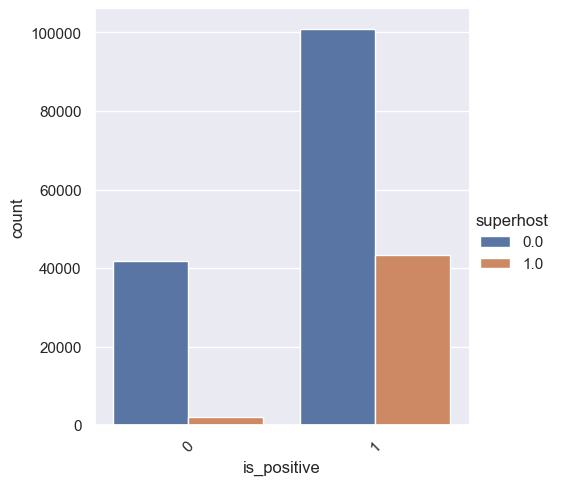

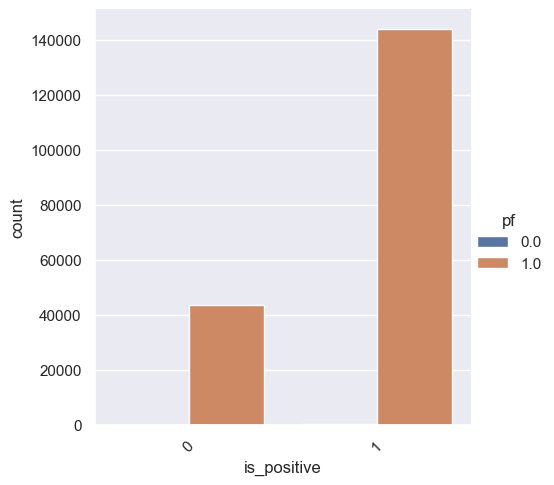

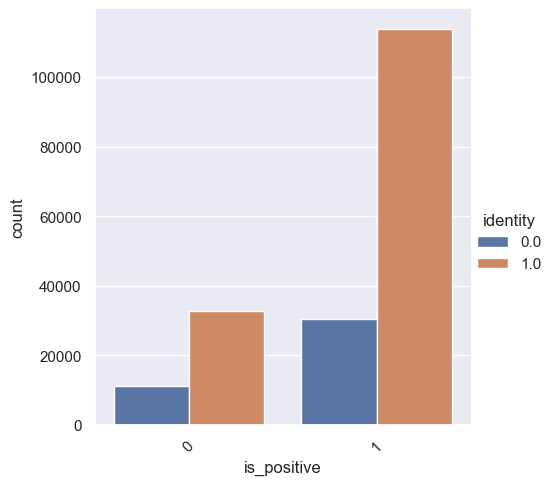

THE CATEGORICAL FEATURE is_positive or is_positive HAS TOO MANY CATEGORIES
PLEASE MAKE SURE TO HAVE CATEGORICAL FEATURE WITH A REASONABLE NUMBER OF CATEGORIES


In [98]:
# let's see how
visualize_interaction(host_df, feature='is_positive', use_cols=list(host_df.columns)) 

The visualizations above are quite intriguing as they lead a number of notable observations:
1. The acceptance rate are of little to no importance in the classification
2. More investigation is needed for the response time and response rate
3. The superhost is indeed a very informative feature. A super host rarely offers a negative user-experience
5. The profile picture as well as the identity of the host do not seem to affect the user's experience 


In [99]:
# drop non-needed columns
df.drop(columns=['res_rate', 'acceptance_rate', 'pf'], inplace=True) 

# Geographical location

## City

In [100]:
# even though specifics generally do not hurt, they may distract us from the big picture, the exact coordinates are not needed (at least at this stage)
df.drop(columns=['longitude','latitude'], inplace=True)

Please make sure to input two different categorical columns


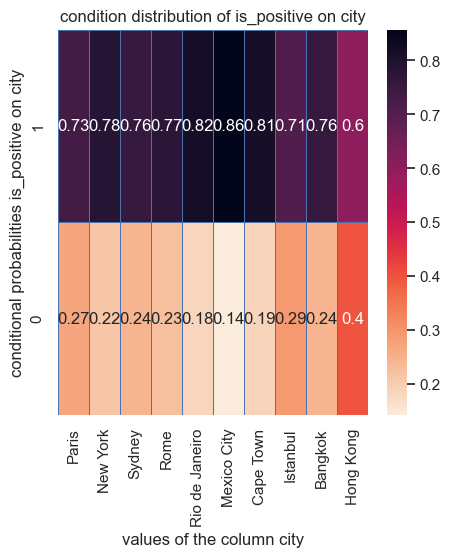

In [101]:
GEO_LOCS = ['neighbourhood', 'city']
# let's consider the conditional probabilities
for g in GEO_LOCS:
    visualize_cond_prob(df, target='is_positive', hue=g)

Apparently the city with the best user-experiences is Mexico City. On other hand one needs to be a bit more careful when booking a listing in Honk Kong.

## Price

In [102]:
# since the price is expressed in the local currency, it is quite important to express the price in terms of its quantile with respect to all the prices in that country
from empiricaldist import Cdf


def produce_cdfs(df: pd.DataFrame, hue_column: str, target_column: str):
    # the column should represent discrete values too
    counter = Counter()
    for value in df[hue_column].value_counts().index:
        counter[value] = Cdf.from_seq(df[df[hue_column] == value][target_column].tolist())
    return counter

PRICE_BY_CITY_CDFS = produce_cdfs(df, hue_column='city', target_column='price')


In [103]:
def convert_price(row):
    # extract the corresponding cfd
    cdf = PRICE_BY_CITY_CDFS[row['city']]
    row['price_relative'] = round(cdf.forward(row['price']) * 100, 2) # convert the probability to percentage
    return row

df = df.apply(convert_price, axis=1)

In [104]:
# let's consider the linear correlation between the price and the target variable
df[['price', 'price_relative', 'is_positive']].corr()
# the idea introduced some improvement, but not a significant one.

,price,price_relative,is_positive
price,1.000000,0.568748,0.062753
price_relative,0.568748,1.000000,0.079061
is_positive,0.062753,0.079061,1.000000


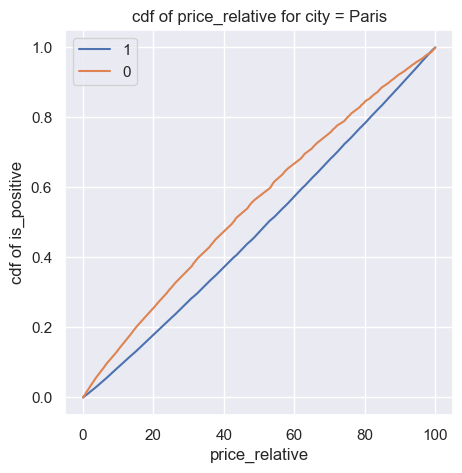

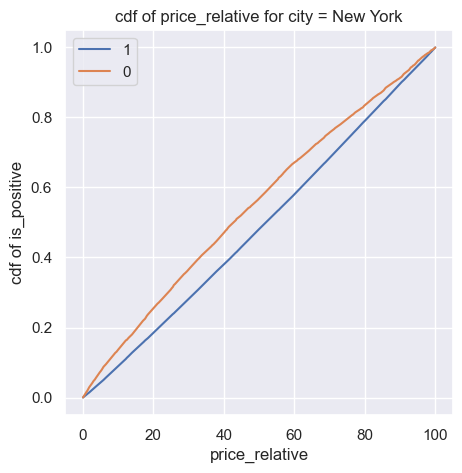

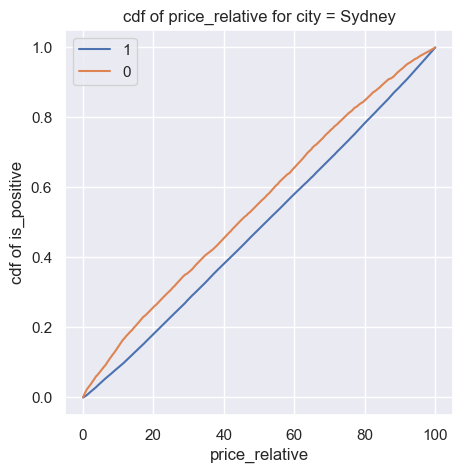

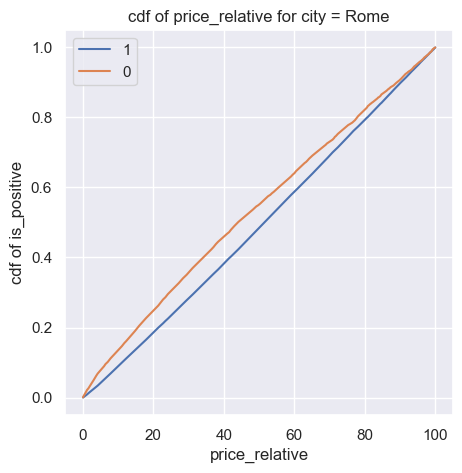

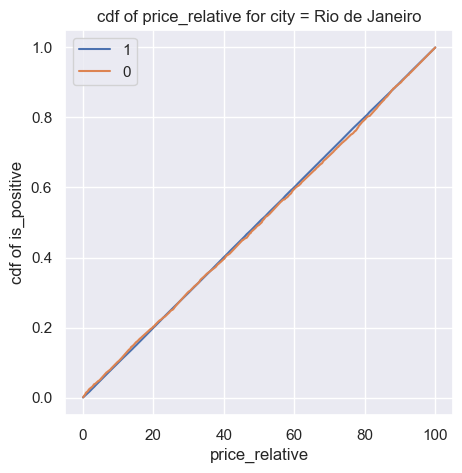

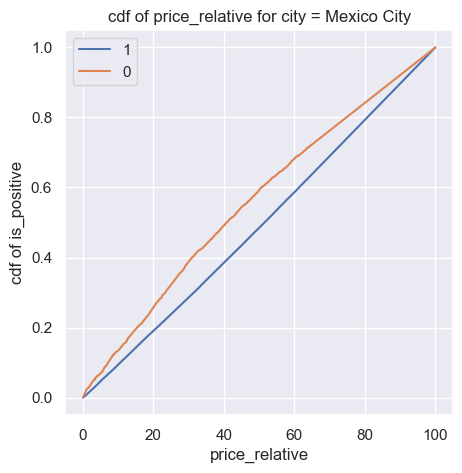

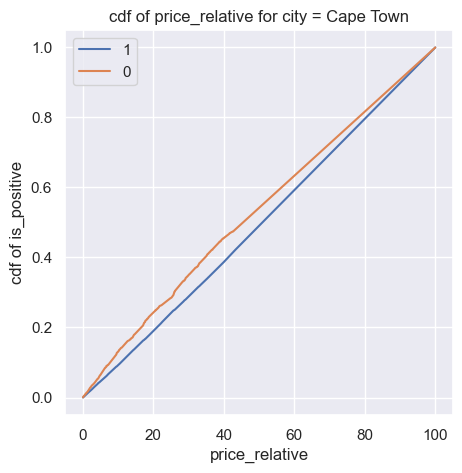

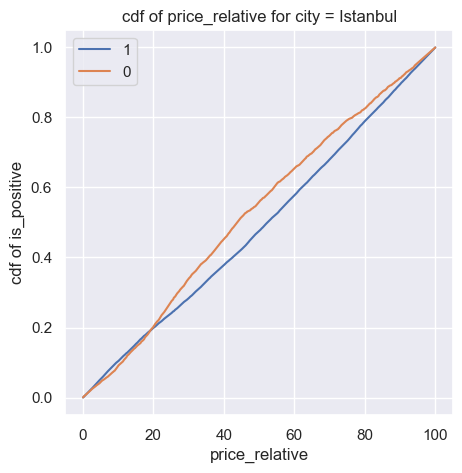

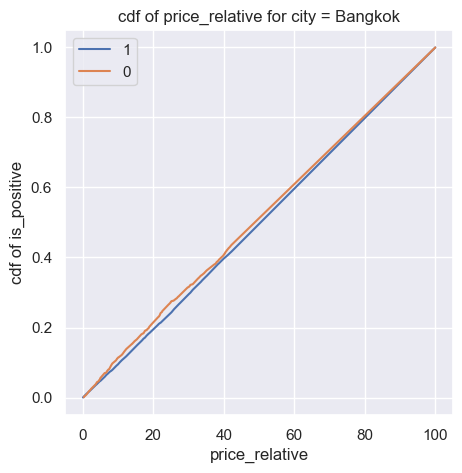

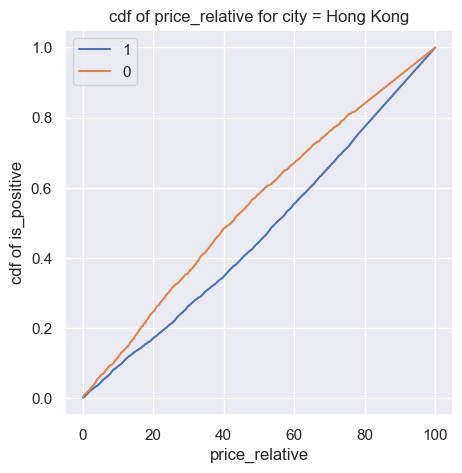

In [105]:
# it seems that the relative place alone is not very informative, let's explore how it varies from one country (city) to another
for city in df['city'].value_counts().index:
    city_data = df[df['city'] == city]
    visualize_num_cat(data=city_data, num_feat='price_relative', cat_feat='is_positive', num_cat='cdf', title=f'cdf of price_relative for city = {city}')

The price is most influential in **HONG KONG**. Nevertheless, It is of relatively limited effect: it has almost no interaction with the dependent variable in the case of **RIO DE JANEIRO**

## City and Neighbourhodd

In [106]:
N = 'neighbourhood' 
# let's display the number of unique neighborhoods in each city
pd.pivot_table(data=df, index='city', values=N, aggfunc=lambda x: len(x.value_counts()))

,neighbourhood
city,
Bangkok,50
Cape Town,81
Hong Kong,18
Istanbul,39
Mexico City,16
New York,218
Paris,20
Rio de Janeiro,132
Rome,15


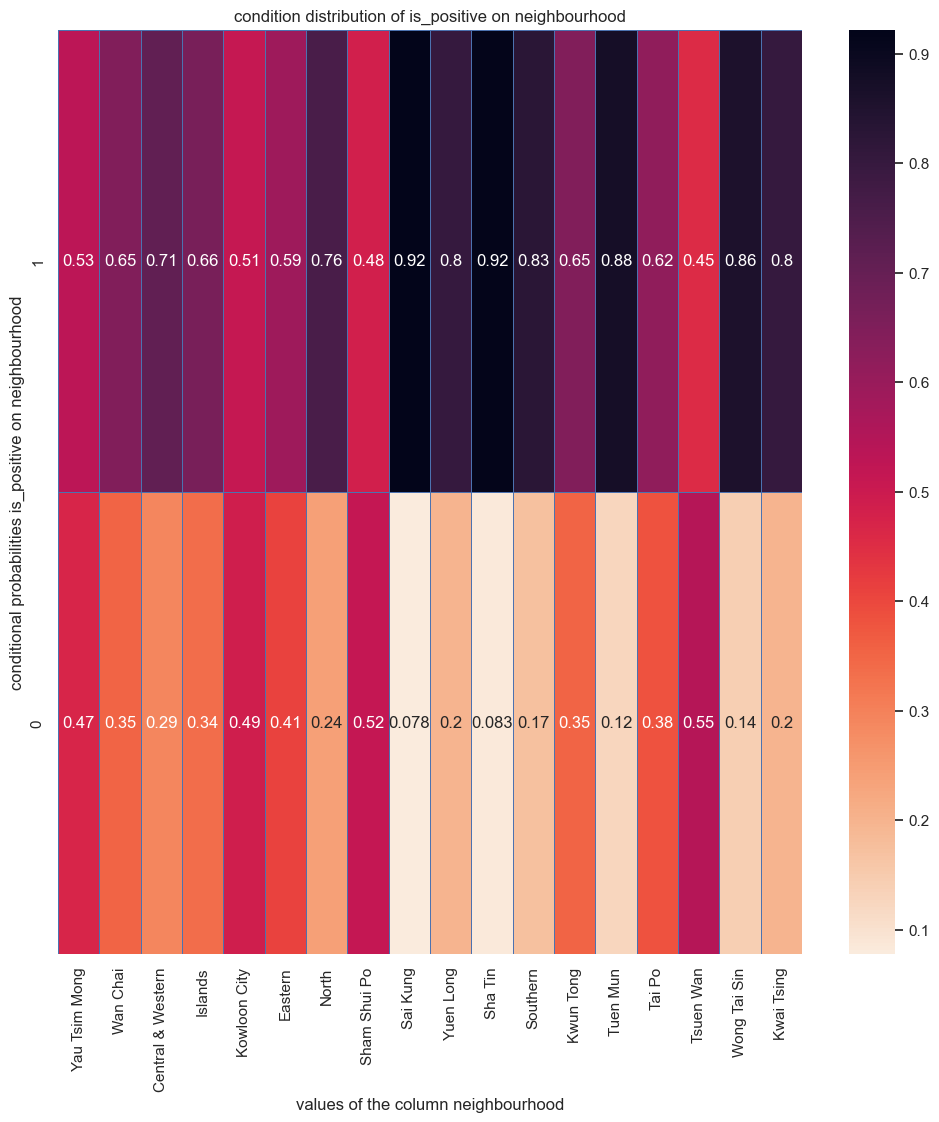

In [107]:
# let's have a random sample of neighbourhoods and see if we can apply some feature enginnering
sns.set(rc={"figure.figsize":(12, 12)})
visualize_cond_prob(df[df['city'] == 'Hong Kong'], target='is_positive', hue=N)

In [108]:
# it seems that the neighborhood information is quite valuable
# create a dictionary to map each value

n_counter = Counter()
for city in df['city'].value_counts().index:
    df_city =  df[df['city'] == city]
    # iterate through each neighbourhood in this temporary dataframe
    for n in df_city[N].value_counts().index:
        total = len(df_city[df_city[N] == n])
        neg = len(df_city[(df_city[N] == n) & (df_city['is_positive'] == True)])
        n_counter.update({n: 1 - (neg / total)})

def set_N(row):
    row['N'] = n_counter[row[N]]
    return row

df = df.apply(set_N, axis=1)

In [109]:
# let's convert the cities to numerical representations
city_counter = Counter()
for city in df['city'].value_counts().index:
    city_num = len(df[df['city'] == city])
    nen_city = len(df[(df['city'] == city) & (df['is_positive'] == 1)])
    city_counter.update({city: 1 - (nen_city / city_num)})

def set_city(row):
    row['city_num'] = city_counter[row['city']]
    return row
df = df.apply(set_city, axis=1)

In [110]:
print(df[['N', 'is_positive', 'city_num']].corr())

                    N  is_positive  city_num
N            1.000000    -0.154874  0.712964
is_positive -0.154874     1.000000 -0.110419
city_num     0.712964    -0.110419  1.000000


THE EXACT NEIGHBOURHOOD PROVIDES RELATIVELY MORE INFORMATION THAN THE CITY IN GENERAL. (THE NUMERICAL REPRESENTATION STILL NEEDS TO BE IMPROVED HOWEVER).

In [111]:
# drop the unused features
df.drop(columns=[N,'final_amenities', 'amenities', 'city', 'price', 'review_scores_rating'], inplace=True)

In [112]:
res_times = df['res_time'].value_counts().index.tolist()
res_times
# let's convert the numbers 
res_times_counter = Counter()

for r in res_times:
    res_times_counter.update({r:len(df[df['res_time'] == r]) / len(df)})

res_times_freqs = list(res_times_counter.values())

freqs = list(np.cumsum(res_times_freqs))
freqs.insert(0, 0)
for r_t, f in zip(res_times, freqs[:-1]):
    res_times_counter[r_t] = round(f, 2)

In [113]:
def set_res_time(row):
    row['res_time'] = res_times_counter[row['res_time']]
    return row
df = df.apply(set_res_time, axis=1)
df.dropna(inplace=True)

In [114]:
print(df.dtypes)
data = df.copy()

host_since          float64
res_time            float64
superhost           float64
ls_count            float64
identity            float64
accommodates          int64
instant_bookable      int64
is_positive           int64
amenities_score     float64
host_as_amenity       int64
listing_exp         float64
price_relative      float64
N                   float64
city_num            float64
dtype: object


OUR DATA IS NOW READY FOR MODELING.

# Modeling: Random Forest

In [115]:
X = data.copy()
y = X.pop('is_positive')

In [116]:
# first let's split the data into 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

TAKING INTO ACCOUNT THE NATURE OF OUR DATA:
1. non-linear relation between the dependent variables and target variable
2. absence of normal distributions of features

Using linear models such as Logistic Regression, SVM is not the best option. On the other hand, "Random Forests" is quite powerful models that does not make any assumptions on the data. Additionally, it is characterized with low bias and lower variance than Decision Trees so overfitting is less likely. Additionally, the model is interpretable which is significant in a business context.

In [117]:
trained = True

In [130]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV


params = {"max_depth": range(3, 7), "n_estimators": np.linspace(100, 200, 6).astype(int), 'min_samples_leaf': np.linspace(0.01, 0.05, 6), "max_features": np.linspace(0.5, 0.8, 4)}
print(params)

if not trained:
    # # no need for scaling or normalizing the data !!
    params = {"max_depth": range(3, 7), "n_estimators": np.linspace(100, 200, 6).astype(int), 'min_samples_leaf': np.linspace(0.01, 0.05, 6), "max_features": np.linspace(0.5, 0.8, 4)}

    print(params)

    # perform cross validation using Grid Serach

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

    # set the random state for reproducibility
    rf_base = RandomForestClassifier(random_state=11)


    from sklearn.metrics import f1_score
    from sklearn.model_selection import RandomizedSearchCV
    # hyper tune the model
    hypertune = RandomizedSearchCV(estimator=rf_base, param_distributions=params, n_iter=200, scoring=f1_score, n_jobs=-1, random_state=11, cv=kfold, verbose=2)

    hypertune.fit(X_train, y_train)

{'max_depth': range(3, 7), 'n_estimators': array([100, 120, 140, 160, 180, 200]), 'min_samples_leaf': array([0.01 , 0.018, 0.026, 0.034, 0.042, 0.05 ]), 'max_features': array([0.5, 0.6, 0.7, 0.8])}


In [127]:
# let's evaluate the predictions
print(f1_score(y_true=y_test, y_pred=y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=y_pred))

0.8683386532907738
              precision    recall  f1-score   support

           0       0.58      0.05      0.09      8776
           1       0.77      0.99      0.87     28853

    accuracy                           0.77     37629
   macro avg       0.68      0.52      0.48     37629
weighted avg       0.73      0.77      0.69     37629



In [122]:
from joblib import dump, load
if not trained:
    model = hypertune.best_estimator_
else: 
    model = load('airbnb_model.joblib')
# time to retrain the model on the entire dataset
model.fit(X_train, y_train)
# now time to predict on the test dataset
y_pred = model.predict(X_test)

dump(model, 'airbnb_model.joblib')


['airbnb_model.joblib']

In [128]:
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_true=y_test, y_pred=y_pred, )

array([[  403,  8373],
       [  289, 28564]], dtype=int64)

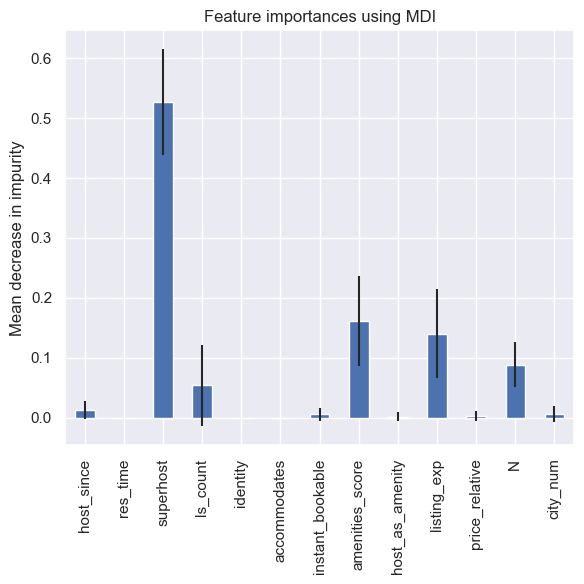

In [132]:
sns.set(rc={"figure.figsize":(6, 6)})

importances = model.feature_importances_

forest_importances = pd.Series(importances, index=X.columns)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()